In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import time

## Pandas Settings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Colors
b = '\033[1m'
n = '\033[0m'

# FUNCIONES

In [2]:
def conjuntoTrainValTest(dfX,dfY):
    # Generar conjunto Entrenamiento y Test
    X_train, X_test, y_train, y_test = train_test_split(dfX, 
                                                        dfY, 
                                                        test_size=0.2, 
                                                        random_state=42,
                                                        stratify=dfX['CODI EOI'])
    # Generar conjunto Validacion
    X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.25, 
                                                  random_state=42,
                                                  stratify=X_train['CODI EOI'])
    # Eliminar columnas Cod Estacion
    X_train.drop(columns=['CODI EOI'],axis=1,inplace=True)
    X_val.drop(columns=['CODI EOI'],axis=1,inplace=True)
    X_test.drop(columns=['CODI EOI'],axis=1,inplace=True)
    # Generar Dataset LigthGBM
    train_data = lgb.Dataset(X_train, label = y_train)
    val_data = lgb.Dataset(X_val, y_val, reference=train_data)
    # Return
    return train_data,val_data,X_test,y_test

In [3]:
def aplicacionModelo(params,nombreModelo,evaluar,train_data,val_data,X_test,y_test):
    start_time = time.time()
    # Entrenamiento Modelo
    model = lgb.train(params,
                      train_data,
                      valid_sets=[train_data, val_data],
                      valid_names=['train','valid'],
                      num_boost_round=5000,
                      early_stopping_rounds=100,
                      verbose_eval=evaluar)
    duracion = (time.time() - start_time)/60
    # Guardado Modelo
    model.save_model('..\Datos\MODELOS\Generales\Modelo_'+str(nombreModelo)+'.pkl')
    # Predicción y R2
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    # R2 adjusted
    n = X_test.shape[0]
    p = X_test.shape[1]
    r2_adj = (1-(1-r2)*(n-1)/(n-p-1))
    # Pearson Corr
    pearson = np.corrcoef(np.hstack(np.array(y_test)), y_pred)[0][1]
    # Feature Importance
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),
                                          model.feature_name()),
                                      reverse=True), 
                               columns=['Value','Feature'])
    # Evaluacion
    print(f'#### RESULTADOS MODELO ####\n')
    print(f'R2 : {r2.round(4)} \t || \t R2adj : {r2_adj.round(4)} \t || \t Rpearson : {pearson.round(4)}')
    print(f'\nTiempo de ejecución: {round(duracion,2)} minutos')
    # Return
    return model,feature_imp

In [73]:
def featImportancePlot(df,name,rowLim):
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data = df.iloc[0:rowLim,:])
    plt.title(f'LightGBM Feature Importance - {name}',fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.savefig('..\Datos\MODELOS\Generales\Plot_Modelo_'+str(name)+'.png')
    plt.show()

In [5]:
def modeloEstacionesInd(df,params):
    estaciones = np.sort(df['CODI EOI'].unique())
    df_impact=pd.DataFrame(columns=['Value','Feature','Cod_Estacion'])
    resultados = pd.DataFrame()
    errorList_estaciones = []
    for i,v in enumerate(estaciones):
        print(f'{i+1} - Procesando estación {v}')
        # Filtrado DF por codigo de estación
        df_aux = df[df['CODI EOI'] == v]
        # Seleccion de variables de interes
        df_auxY = df_aux[['O3']]
        df_aux = df_aux.iloc[:,np.r_[0,2,3,5:434]]
        # Generar conjuntos de entrenamiento y validación
        train_data,val_data,X_test,y_test = conjuntoTrainValTest(df_aux,df_auxY)
        # Entrenar modelo
        model = lgb.train(params,
                          train_data,
                          valid_sets=[train_data, val_data],
                          valid_names=['train','valid'],
                          num_boost_round=5000,
                          early_stopping_rounds=100,
                          verbose_eval=False)
        model.save_model('..\Datos\MODELOS\Estaciones\Modelo_'+str(v)+'.pkl')
        # Predicción
        y_pred = model.predict(X_test)
        # error
        e = np.hstack(np.array(y_test)) - y_pred
        errorList_estaciones.append(e)
        # R2
        r2 = r2_score(y_test, y_pred)
        # R2 adjusted
        n = X_test.shape[0]
        p = X_test.shape[1]
        r2_adj = (1-(1-r2)*(n-1)/(n-p-1))
        # Pearson Corr
        pearson = np.corrcoef(np.hstack(np.array(y_test)), y_pred)[0][1]
        # DF resultados
        auxList = [str(v),r2,r2_adj,pearson]
        resultados = resultados.append([auxList])
        # Generar DF Feature Importance
        feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(),model.feature_name()),reverse=True),
                                   columns=['Value','Feature'])
        feature_imp['Cod_Estacion'] = str(v)
        # Imagen 
        plt.figure(figsize=(20, 10))
        sns.barplot(x="Value", y="Feature", data = feature_imp.iloc[0:10,:])
        plt.title('LightGBM Feature Importance '+str(v))
        plt.tight_layout()
        plt.savefig('..\Datos\MODELOS\Estaciones\Modelo_Plot_'+str(v)+'.png')
        plt.show()
        plt.close()
        # DF append
        feature_imp = feature_imp[feature_imp['Value']>0]
        df_impact = df_impact.append(feature_imp)
    # Formato DF resultados e impacto
    resultados.columns = ['Estacion','R2','R2adj','Pearson']
    resultados.reset_index(drop = True,inplace = True)
    df_impact = df_impact[['Cod_Estacion','Feature','Value']]
    df_impact.sort_values(by=['Cod_Estacion','Value'],ascending = False,inplace = True)
    # RETURN
    return resultados,df_impact,errorList_estaciones

# Carga DF Concentraciones O3

In [6]:
filename = '..\Datos\Datos_Procesados\DF_Mediciones_Predictores'
infile = open(filename,'rb')
df = pickle.load(infile)
infile.close()

In [7]:
df.head(1)

,CODI EOI,NOM ESTACIO,FECHA,O3,NO2,NO2_t_1,NO2_diff,TIPO_DIA,u10,v10,t2m,ssrd,tp,b25,b50,b100,b300,b500,b1000,b1500,b2000,b2500,b3000,b3500,b4000,b4500,b5000,residential_b25,service_b25,tertiary_b25,primary_b50,residential_b50,secondary_b50,service_b50,tertiary_b50,unclassified_b50,primary_b100,residential_b100,secondary_b100,service_b100,tertiary_b100,unclassified_b100,motorway_b300,primary_b300,residential_b300,secondary_b300,service_b300,tertiary_b300,trunk_b300,unclassified_b300,motorway_b500,primary_b500,residential_b500,secondary_b500,service_b500,tertiary_b500,trunk_b500,unclassified_b500,motorway_b1000,primary_b1000,residential_b1000,secondary_b1000,service_b1000,tertiary_b1000,trunk_b1000,unclassified_b1000,motorway_b1500,primary_b1500,residential_b1500,secondary_b1500,service_b1500,tertiary_b1500,trunk_b1500,unclassified_b1500,motorway_b2000,primary_b2000,residential_b2000,secondary_b2000,service_b2000,tertiary_b2000,trunk_b2000,unclassified_b2000,motorway_b2500,primary_b2500,residential_b2500,secondary_b2500,service_b2500,tertiary_b2500,trunk_b2500,unclassified_b2500,motorway_b3000,primary_b3000,residential_b3000,secondary_b3000,service_b3000,tertiary_b3000,trunk_b3000,unclassified_b3000,motorway_b3500,primary_b3500,residential_b3500,secondary_b3500,service_b3500,tertiary_b3500,trunk_b3500,unclassified_b3500,motorway_b4000,primary_b4000,residential_b4000,secondary_b4000,service_b4000,tertiary_b4000,trunk_b4000,unclassified_b4000,motorway_b4500,primary_b4500,residential_b4500,secondary_b4500,service_b4500,tertiary_b4500,trunk_b4500,unclassified_b4500,motorway_b5000,primary_b5000,residential_b5000,secondary_b5000,service_b5000,tertiary_b5000,trunk_b5000,unclassified_b5000,contUrbFab_b25,discDensUrbFab_b25,discLowDensUrbFab_b25,discMedDensUrbFab_b25,discVLowDensUrbFab_b25,forest_b25,grUrbAreas_b25,herbVegetation_b25,industryCommercial_b25,otherRoads_b25,pastures_b25,railways_b25,sports_b25,annualCrops_b50,contUrbFab_b50,discDensUrbFab_b50,discLowDensUrbFab_b50,discMedDensUrbFab_b50,discVLowDensUrbFab_b50,forest_b50,grUrbAreas_b50,herbVegetation_b50,industryCommercial_b50,landNoUse_b50,otherRoads_b50,pastures_b50,railways_b50,sports_b50,water_b50,annualCrops_b100,contUrbFab_b100,discDensUrbFab_b100,discLowDensUrbFab_b100,discMedDensUrbFab_b100,discVLowDensUrbFab_b100,fastRoads_b100,forest_b100,grUrbAreas_b100,herbVegetation_b100,industryCommercial_b100,landNoUse_b100,mininDump_b100,otherRoads_b100,pastures_b100,railways_b100,sports_b100,water_b100,annualCrops_b300,constructionSites_b300,contUrbFab_b300,discDensUrbFab_b300,discLowDensUrbFab_b300,discMedDensUrbFab_b300,discVLowDensUrbFab_b300,fastRoads_b300,forest_b300,grUrbAreas_b300,herbVegetation_b300,industryCommercial_b300,isolStruct_b300,landNoUse_b300,mininDump_b300,otherRoads_b300,pastures_b300,railways_b300,sports_b300,water_b300,annualCrops_b500,constructionSites_b500,contUrbFab_b500,discDensUrbFab_b500,discLowDensUrbFab_b500,discMedDensUrbFab_b500,discVLowDensUrbFab_b500,fastRoads_b500,forest_b500,grUrbAreas_b500,herbVegetation_b500,industryCommercial_b500,isolStruct_b500,landNoUse_b500,mininDump_b500,otherRoads_b500,pastures_b500,permanentCrops_b500,railways_b500,sports_b500,water_b500,airports_b1000,annualCrops_b1000,constructionSites_b1000,contUrbFab_b1000,discDensUrbFab_b1000,discLowDensUrbFab_b1000,discMedDensUrbFab_b1000,discVLowDensUrbFab_b1000,fastRoads_b1000,forest_b1000,grUrbAreas_b1000,herbVegetation_b1000,industryCommercial_b1000,isolStruct_b1000,landNoUse_b1000,mininDump_b1000,opSpaceNoVeg_b1000,otherRoads_b1000,pastures_b1000,permanentCrops_b1000,railways_b1000,sports_b1000,water_b1000,airports_b1500,annualCrops_b1500,constructionSites_b1500,contUrbFab_b1500,discDensUrbFab_b1500,discLowDensUrbFab_b1500,discMedDensUrbFab_b1500,discVLowDensUrbFab_b1500,fastRoads_b1500,forest_b1500,grUrbAreas_b1500,herbVegetation_b1500,industryCommercial_b1500,isolStruct_b1500,landNoUse_b1500,mininDump_b1500,opSpaceNoVeg_b1500,otherRoads_b1500,pastures_b1500,permanen

In [82]:
df.shape

(337815, 434)

## Análisis Concentraciones

<AxesSubplot:xlabel='O3'>

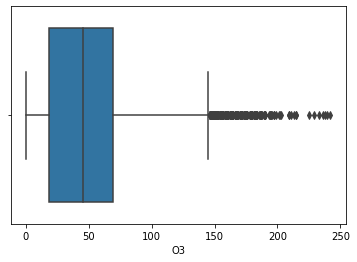

In [8]:
sns.boxplot(x=df['O3'])

In [9]:
df['O3'].describe()

count    337815.000000
mean         46.063245
std          31.591972
min           0.000000
25%          18.000000
50%          45.000000
75%          69.000000
max         242.000000
Name: O3, dtype: float64

## Eliminar Columnas y generar DFX y DFY

<!-- ## Preparación DF -->

Borrar Columna **FECHA** y **NOM ESTACIO**:

In [10]:
df.drop(columns=['NOM ESTACIO'],axis=1,inplace=True)

## Shuffle de Rows --> Aleatorización

In [11]:
df = df.sample(frac=1).reset_index(drop=True)

In [12]:
df.head()

,CODI EOI,FECHA,O3,NO2,NO2_t_1,NO2_diff,TIPO_DIA,u10,v10,t2m,ssrd,tp,b25,b50,b100,b300,b500,b1000,b1500,b2000,b2500,b3000,b3500,b4000,b4500,b5000,residential_b25,service_b25,tertiary_b25,primary_b50,residential_b50,secondary_b50,service_b50,tertiary_b50,unclassified_b50,primary_b100,residential_b100,secondary_b100,service_b100,tertiary_b100,unclassified_b100,motorway_b300,primary_b300,residential_b300,secondary_b300,service_b300,tertiary_b300,trunk_b300,unclassified_b300,motorway_b500,primary_b500,residential_b500,secondary_b500,service_b500,tertiary_b500,trunk_b500,unclassified_b500,motorway_b1000,primary_b1000,residential_b1000,secondary_b1000,service_b1000,tertiary_b1000,trunk_b1000,unclassified_b1000,motorway_b1500,primary_b1500,residential_b1500,secondary_b1500,service_b1500,tertiary_b1500,trunk_b1500,unclassified_b1500,motorway_b2000,primary_b2000,residential_b2000,secondary_b2000,service_b2000,tertiary_b2000,trunk_b2000,unclassified_b2000,motorway_b2500,primary_b2500,residential_b2500,secondary_b2500,service_b2500,tertiary_b2500,trunk_b2500,unclassified_b2500,motorway_b3000,primary_b3000,residential_b3000,secondary_b3000,service_b3000,tertiary_b3000,trunk_b3000,unclassified_b3000,motorway_b3500,primary_b3500,residential_b3500,secondary_b3500,service_b3500,tertiary_b3500,trunk_b3500,unclassified_b3500,motorway_b4000,primary_b4000,residential_b4000,secondary_b4000,service_b4000,tertiary_b4000,trunk_b4000,unclassified_b4000,motorway_b4500,primary_b4500,residential_b4500,secondary_b4500,service_b4500,tertiary_b4500,trunk_b4500,unclassified_b4500,motorway_b5000,primary_b5000,residential_b5000,secondary_b5000,service_b5000,tertiary_b5000,trunk_b5000,unclassified_b5000,contUrbFab_b25,discDensUrbFab_b25,discLowDensUrbFab_b25,discMedDensUrbFab_b25,discVLowDensUrbFab_b25,forest_b25,grUrbAreas_b25,herbVegetation_b25,industryCommercial_b25,otherRoads_b25,pastures_b25,railways_b25,sports_b25,annualCrops_b50,contUrbFab_b50,discDensUrbFab_b50,discLowDensUrbFab_b50,discMedDensUrbFab_b50,discVLowDensUrbFab_b50,forest_b50,grUrbAreas_b50,herbVegetation_b50,industryCommercial_b50,landNoUse_b50,otherRoads_b50,pastures_b50,railways_b50,sports_b50,water_b50,annualCrops_b100,contUrbFab_b100,discDensUrbFab_b100,discLowDensUrbFab_b100,discMedDensUrbFab_b100,discVLowDensUrbFab_b100,fastRoads_b100,forest_b100,grUrbAreas_b100,herbVegetation_b100,industryCommercial_b100,landNoUse_b100,mininDump_b100,otherRoads_b100,pastures_b100,railways_b100,sports_b100,water_b100,annualCrops_b300,constructionSites_b300,contUrbFab_b300,discDensUrbFab_b300,discLowDensUrbFab_b300,discMedDensUrbFab_b300,discVLowDensUrbFab_b300,fastRoads_b300,forest_b300,grUrbAreas_b300,herbVegetation_b300,industryCommercial_b300,isolStruct_b300,landNoUse_b300,mininDump_b300,otherRoads_b300,pastures_b300,railways_b300,sports_b300,water_b300,annualCrops_b500,constructionSites_b500,contUrbFab_b500,discDensUrbFab_b500,discLowDensUrbFab_b500,discMedDensUrbFab_b500,discVLowDensUrbFab_b500,fastRoads_b500,forest_b500,grUrbAreas_b500,herbVegetation_b500,industryCommercial_b500,isolStruct_b500,landNoUse_b500,mininDump_b500,otherRoads_b500,pastures_b500,permanentCrops_b500,railways_b500,sports_b500,water_b500,airports_b1000,annualCrops_b1000,constructionSites_b1000,contUrbFab_b1000,discDensUrbFab_b1000,discLowDensUrbFab_b1000,discMedDensUrbFab_b1000,discVLowDensUrbFab_b1000,fastRoads_b1000,forest_b1000,grUrbAreas_b1000,herbVegetation_b1000,industryCommercial_b1000,isolStruct_b1000,landNoUse_b1000,mininDump_b1000,opSpaceNoVeg_b1000,otherRoads_b1000,pastures_b1000,permanentCrops_b1000,railways_b1000,sports_b1000,water_b1000,airports_b1500,annualCrops_b1500,constructionSites_b1500,contUrbFab_b1500,discDensUrbFab_b1500,discLowDensUrbFab_b1500,discMedDensUrbFab_b1500,discVLowDensUrbFab_b1500,fastRoads_b1500,forest_b1500,grUrbAreas_b1500,herbVegetation_b1500,industryCommercial_b1500,isolStruct_b1500,landNoUse_b1500,mininDump_b1500,opSpaceNoVeg_b1500,otherRoads_b1500,pastures_b1500,permanentCrops_b1500

In [13]:
df.tail()

,CODI EOI,FECHA,O3,NO2,NO2_t_1,NO2_diff,TIPO_DIA,u10,v10,t2m,ssrd,tp,b25,b50,b100,b300,b500,b1000,b1500,b2000,b2500,b3000,b3500,b4000,b4500,b5000,residential_b25,service_b25,tertiary_b25,primary_b50,residential_b50,secondary_b50,service_b50,tertiary_b50,unclassified_b50,primary_b100,residential_b100,secondary_b100,service_b100,tertiary_b100,unclassified_b100,motorway_b300,primary_b300,residential_b300,secondary_b300,service_b300,tertiary_b300,trunk_b300,unclassified_b300,motorway_b500,primary_b500,residential_b500,secondary_b500,service_b500,tertiary_b500,trunk_b500,unclassified_b500,motorway_b1000,primary_b1000,residential_b1000,secondary_b1000,service_b1000,tertiary_b1000,trunk_b1000,unclassified_b1000,motorway_b1500,primary_b1500,residential_b1500,secondary_b1500,service_b1500,tertiary_b1500,trunk_b1500,unclassified_b1500,motorway_b2000,primary_b2000,residential_b2000,secondary_b2000,service_b2000,tertiary_b2000,trunk_b2000,unclassified_b2000,motorway_b2500,primary_b2500,residential_b2500,secondary_b2500,service_b2500,tertiary_b2500,trunk_b2500,unclassified_b2500,motorway_b3000,primary_b3000,residential_b3000,secondary_b3000,service_b3000,tertiary_b3000,trunk_b3000,unclassified_b3000,motorway_b3500,primary_b3500,residential_b3500,secondary_b3500,service_b3500,tertiary_b3500,trunk_b3500,unclassified_b3500,motorway_b4000,primary_b4000,residential_b4000,secondary_b4000,service_b4000,tertiary_b4000,trunk_b4000,unclassified_b4000,motorway_b4500,primary_b4500,residential_b4500,secondary_b4500,service_b4500,tertiary_b4500,trunk_b4500,unclassified_b4500,motorway_b5000,primary_b5000,residential_b5000,secondary_b5000,service_b5000,tertiary_b5000,trunk_b5000,unclassified_b5000,contUrbFab_b25,discDensUrbFab_b25,discLowDensUrbFab_b25,discMedDensUrbFab_b25,discVLowDensUrbFab_b25,forest_b25,grUrbAreas_b25,herbVegetation_b25,industryCommercial_b25,otherRoads_b25,pastures_b25,railways_b25,sports_b25,annualCrops_b50,contUrbFab_b50,discDensUrbFab_b50,discLowDensUrbFab_b50,discMedDensUrbFab_b50,discVLowDensUrbFab_b50,forest_b50,grUrbAreas_b50,herbVegetation_b50,industryCommercial_b50,landNoUse_b50,otherRoads_b50,pastures_b50,railways_b50,sports_b50,water_b50,annualCrops_b100,contUrbFab_b100,discDensUrbFab_b100,discLowDensUrbFab_b100,discMedDensUrbFab_b100,discVLowDensUrbFab_b100,fastRoads_b100,forest_b100,grUrbAreas_b100,herbVegetation_b100,industryCommercial_b100,landNoUse_b100,mininDump_b100,otherRoads_b100,pastures_b100,railways_b100,sports_b100,water_b100,annualCrops_b300,constructionSites_b300,contUrbFab_b300,discDensUrbFab_b300,discLowDensUrbFab_b300,discMedDensUrbFab_b300,discVLowDensUrbFab_b300,fastRoads_b300,forest_b300,grUrbAreas_b300,herbVegetation_b300,industryCommercial_b300,isolStruct_b300,landNoUse_b300,mininDump_b300,otherRoads_b300,pastures_b300,railways_b300,sports_b300,water_b300,annualCrops_b500,constructionSites_b500,contUrbFab_b500,discDensUrbFab_b500,discLowDensUrbFab_b500,discMedDensUrbFab_b500,discVLowDensUrbFab_b500,fastRoads_b500,forest_b500,grUrbAreas_b500,herbVegetation_b500,industryCommercial_b500,isolStruct_b500,landNoUse_b500,mininDump_b500,otherRoads_b500,pastures_b500,permanentCrops_b500,railways_b500,sports_b500,water_b500,airports_b1000,annualCrops_b1000,constructionSites_b1000,contUrbFab_b1000,discDensUrbFab_b1000,discLowDensUrbFab_b1000,discMedDensUrbFab_b1000,discVLowDensUrbFab_b1000,fastRoads_b1000,forest_b1000,grUrbAreas_b1000,herbVegetation_b1000,industryCommercial_b1000,isolStruct_b1000,landNoUse_b1000,mininDump_b1000,opSpaceNoVeg_b1000,otherRoads_b1000,pastures_b1000,permanentCrops_b1000,railways_b1000,sports_b1000,water_b1000,airports_b1500,annualCrops_b1500,constructionSites_b1500,contUrbFab_b1500,discDensUrbFab_b1500,discLowDensUrbFab_b1500,discMedDensUrbFab_b1500,discVLowDensUrbFab_b1500,fastRoads_b1500,forest_b1500,grUrbAreas_b1500,herbVegetation_b1500,industryCommercial_b1500,isolStruct_b1500,landNoUse_b1500,mininDump_b1500,opSpaceNoVeg_b1500,otherRoads_b1500,pastures_b1500,permanentCrops_b1500

In [14]:
df.drop(columns=['FECHA'],axis=1,inplace=True)

## Generar DF de predictores y array con valor objectivo:

In [15]:
dfX = df.iloc[:,np.r_[0,2,5:434]]
dfX_memo_t_1 = df.iloc[:,np.r_[0,2,3,5:434]]
dfX_memo_diff = df.iloc[:,np.r_[0,2,4,5:434]]
dfY = df[['O3']]

# MODELOS GENERALES

Parameter Setting:

In [16]:
params = {'num_leaves': 32,
         'objective': 'regression',
         'boosting':'gbdt',
         'metric': 'rmse',
         'learning_rate': 0.1,         
         'verbose':-1}
# gbdt: traditional gradient boosting decision trees

In [17]:
train_data,val_data,X_test,y_test = conjuntoTrainValTest(dfX,dfY)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## MODELO 1: NO2 sin NO2t-1

Aplicación modelo:

In [18]:
model1,feature_imp = aplicacionModelo(params,'1',False,train_data,val_data,X_test,y_test)

#### RESULTADOS MODELO ####

R2 : 0.8549 	 || 	 R2adj : 0.8539 	 || 	 Rpearson : 0.9247

Tiempo de ejecución: 4.5 minutos


Feature Importance:

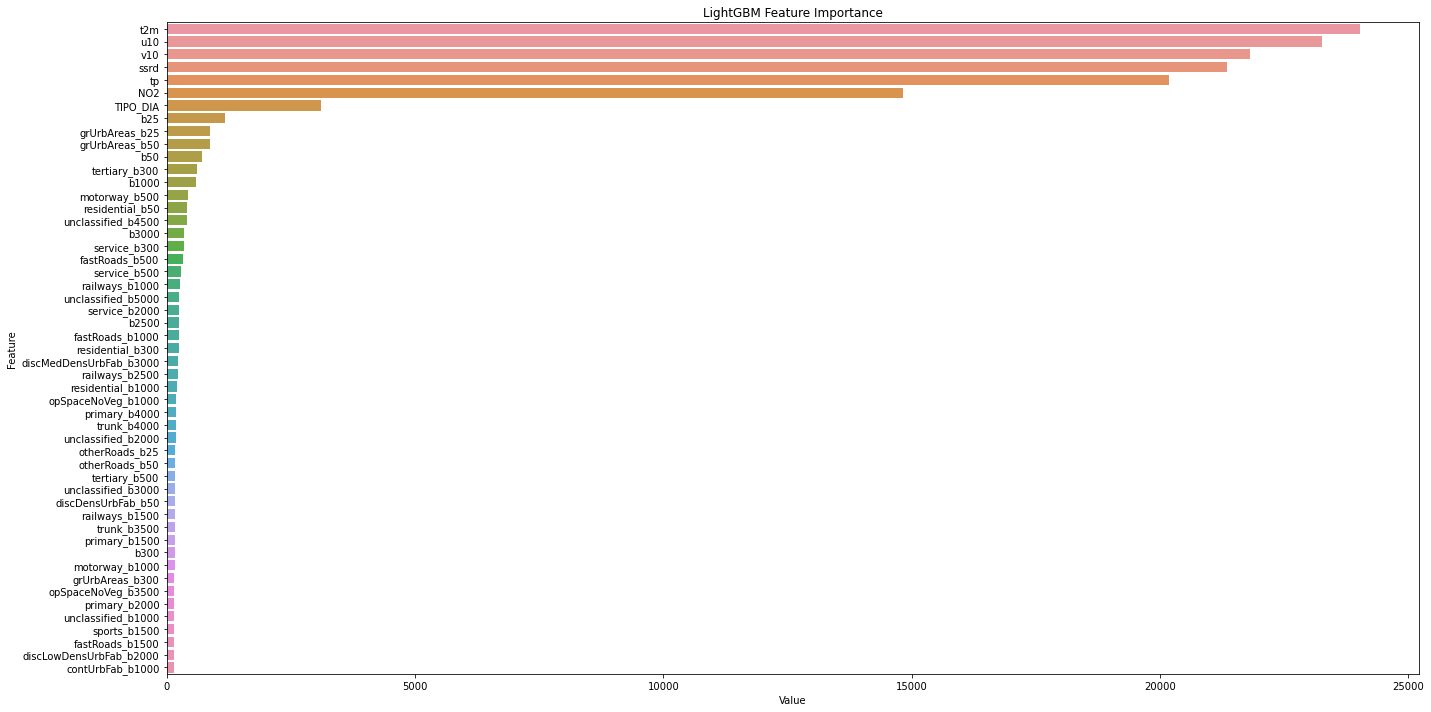

In [19]:
featImportancePlot(feature_imp,'1',51)

Variables que nunca se utilizan:

In [20]:
varsEliminar = list(feature_imp[feature_imp['Value']==0]['Feature'])

## MODELO 2: eliminar variables no utilizadas en arboles del modelo 1

In [21]:
dfX2 = dfX.drop(columns=varsEliminar,axis=1)

In [22]:
train_data,val_data,X_test,y_test = conjuntoTrainValTest(dfX2,dfY)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
model2,feature_imp = aplicacionModelo(params,'2',False,train_data,val_data,X_test,y_test)

#### RESULTADOS MODELO ####

R2 : 0.8549 	 || 	 R2adj : 0.8543 	 || 	 Rpearson : 0.9247

Tiempo de ejecución: 2.68 minutos


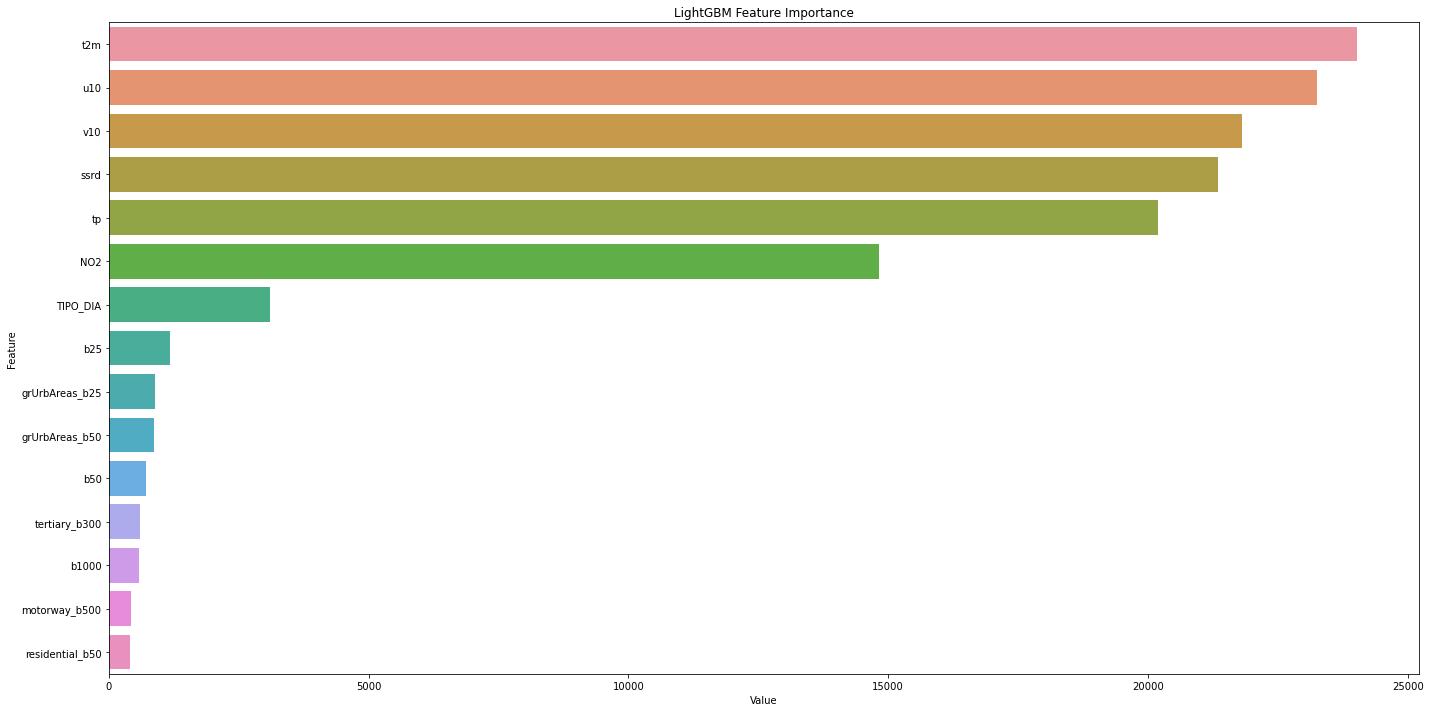

In [24]:
featImportancePlot(feature_imp,'2',15)

## MODELO 3: Variables GEO

In [25]:
df_geo = df.iloc[:,np.r_[0,5,11:434]]
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df_geo,dfY)
model_geo,feature_imp_geo = aplicacionModelo(params,'Geo',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.1305 	 || 	 R2adj : 0.125 	 || 	 Rpearson : 0.3613

Tiempo de ejecución: 0.4 minutos


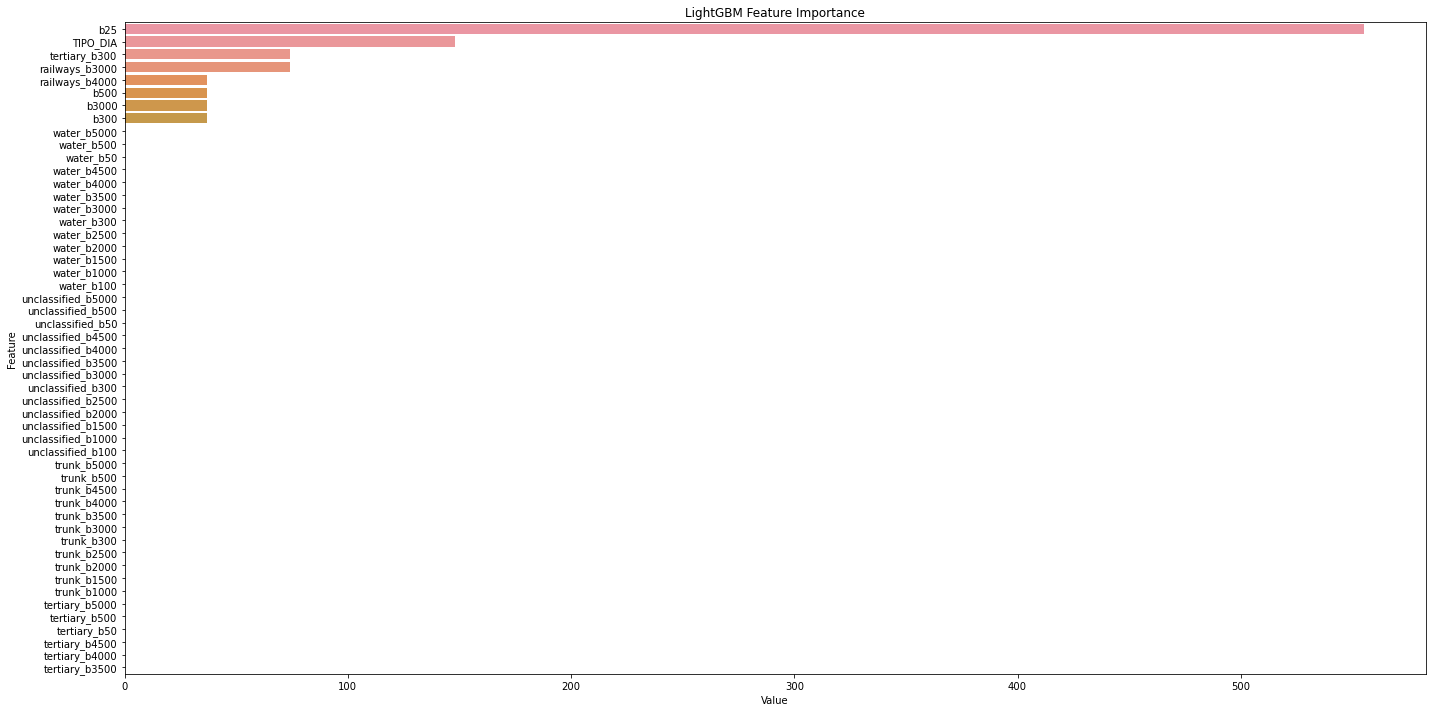

In [26]:
featImportancePlot(feature_imp_geo,'Geo',51)

## MODELO 4: Variables WEATHER

In [27]:
df_weather = df.iloc[:,np.r_[0,6:11]]
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df_weather,dfY)
model_weather,feature_imp_weather = aplicacionModelo(params,'Weather',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.4417 	 || 	 R2adj : 0.4417 	 || 	 Rpearson : 0.6647

Tiempo de ejecución: 0.35 minutos


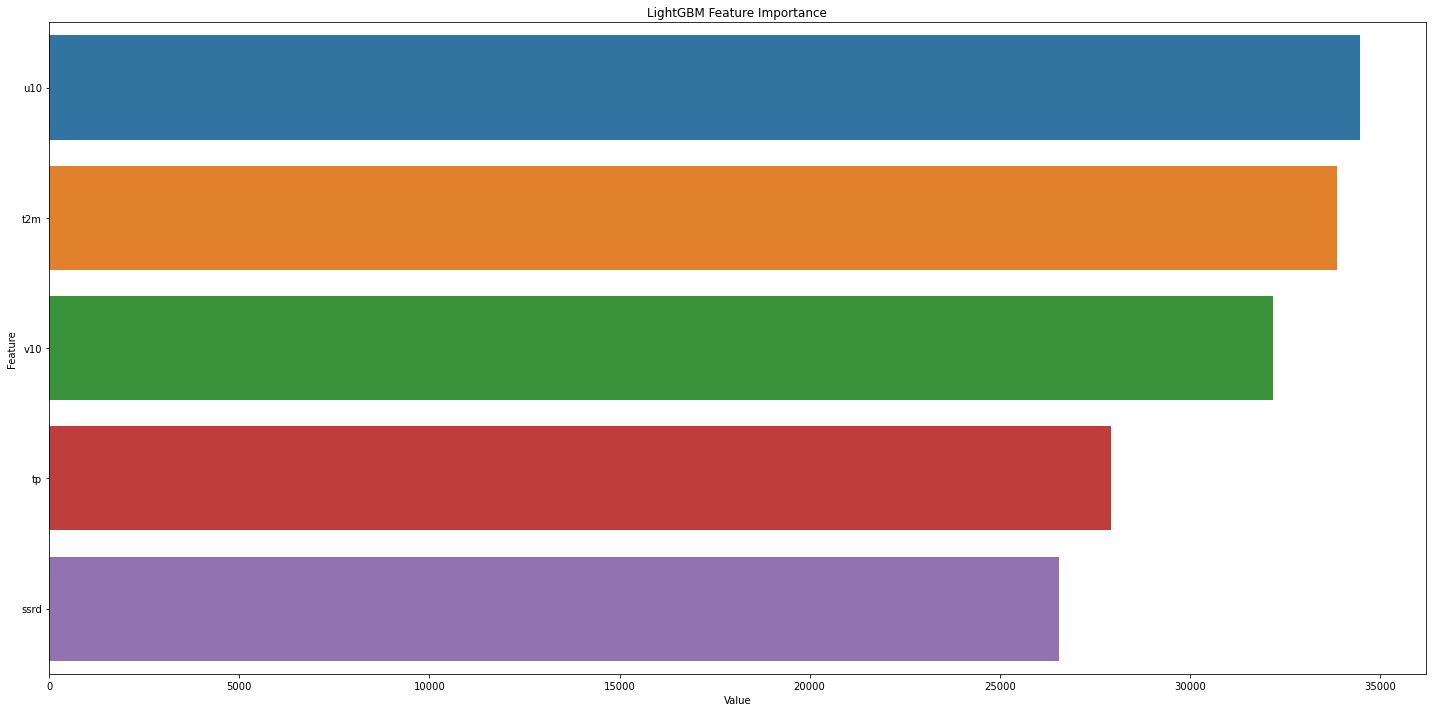

In [28]:
featImportancePlot(feature_imp_weather,'Weather',51)

## MODELO 5: Variables GEO + WEATHER

In [29]:
df5 = df.iloc[:,np.r_[0,5:434]]
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df5,dfY)
model_NoMemo,feature_imp_NoMemo = aplicacionModelo(params,'Geo_Weather',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.6888 	 || 	 R2adj : 0.6868 	 || 	 Rpearson : 0.8304

Tiempo de ejecución: 3.52 minutos


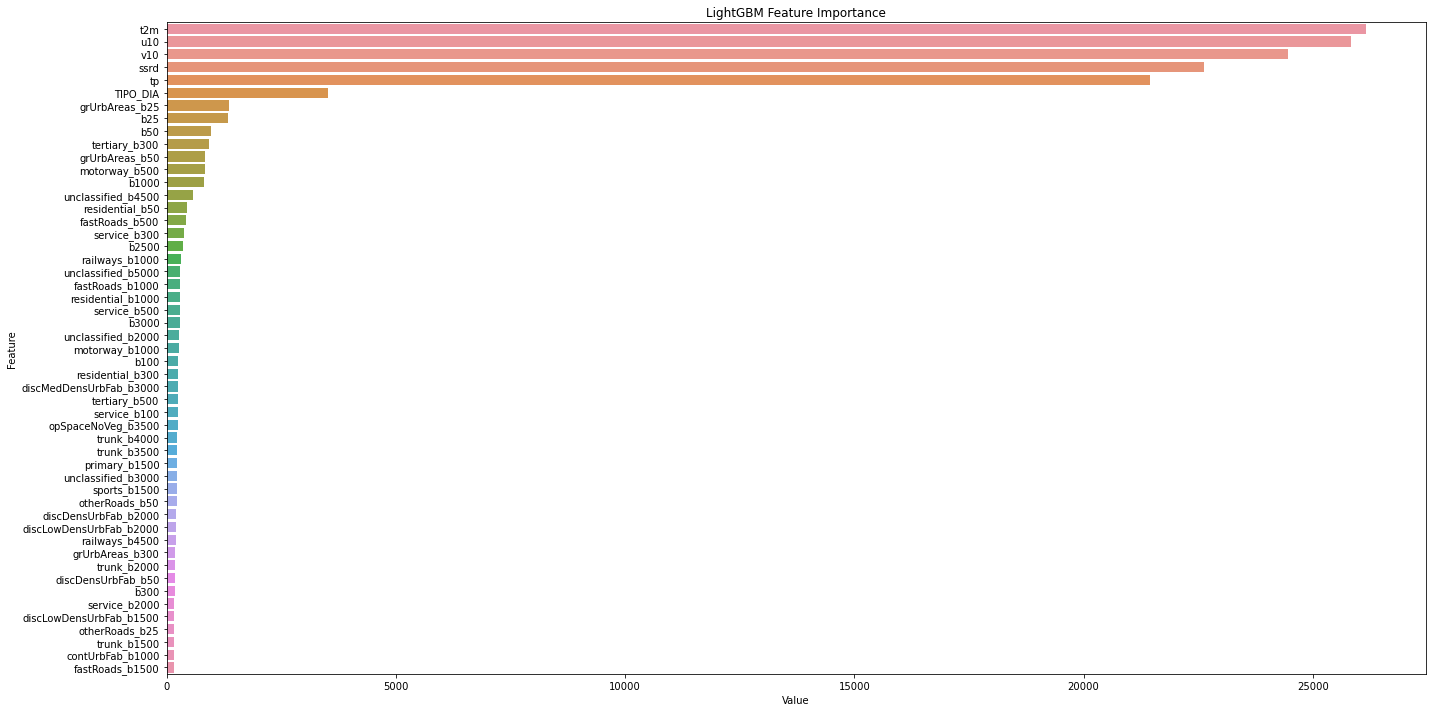

In [30]:
featImportancePlot(feature_imp_NoMemo,'Geo_Weather',51)

## MODELO 6: NO2 + NO2 t-1

In [31]:
df6 = df.iloc[:,np.r_[0,2,3,5:434]]
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df6,dfY)
model_memo1,feature_imp_memo1 = aplicacionModelo(params,'Memo1',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.8571 	 || 	 R2adj : 0.8561 	 || 	 Rpearson : 0.9259

Tiempo de ejecución: 3.56 minutos


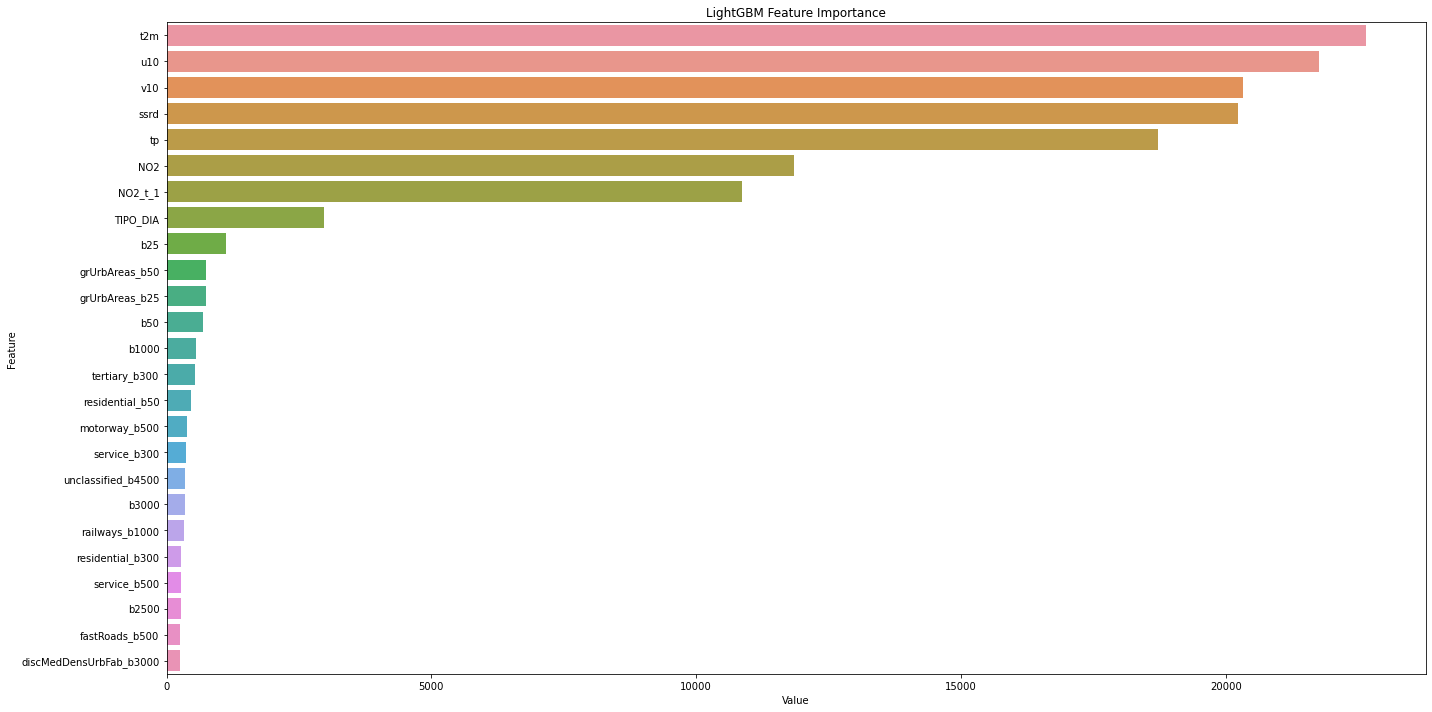

In [32]:
featImportancePlot(feature_imp_memo1,'Memo1',25)

## MODELO 7: 15 Mejores Predictores modelo 6

In [33]:
vars15 = list(feature_imp_memo1.iloc[0:15,:]['Feature'])
vars15.append('CODI EOI')
df_15 = df[vars15]

In [34]:
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df_15,dfY)
model_Memo2,feature_imp_Memo2 = aplicacionModelo(params,'Memo2',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.8578 	 || 	 R2adj : 0.8578 	 || 	 Rpearson : 0.9263

Tiempo de ejecución: 0.42 minutos


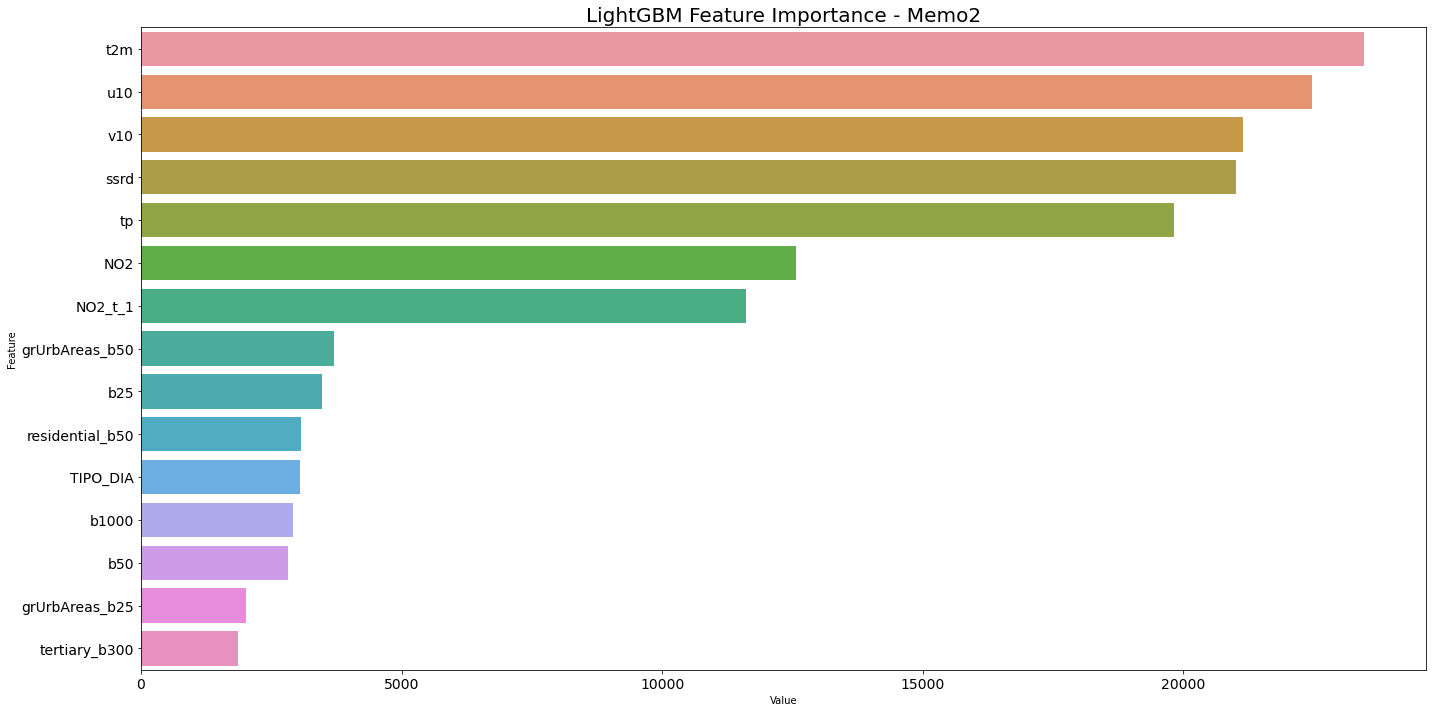

In [74]:
featImportancePlot(feature_imp_Memo2,'Memo2',25)

## MODELO 8: 10 Mejores Predictores modelo 6

In [36]:
vars10 = list(feature_imp_memo1.iloc[0:10,:]['Feature'])
vars10.append('CODI EOI')
df_10 = df[vars10]

In [37]:
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df_10,dfY)
model_Memo3,feature_imp_Memo3 = aplicacionModelo(params,'Memo3',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.8564 	 || 	 R2adj : 0.8564 	 || 	 Rpearson : 0.9256

Tiempo de ejecución: 0.34 minutos


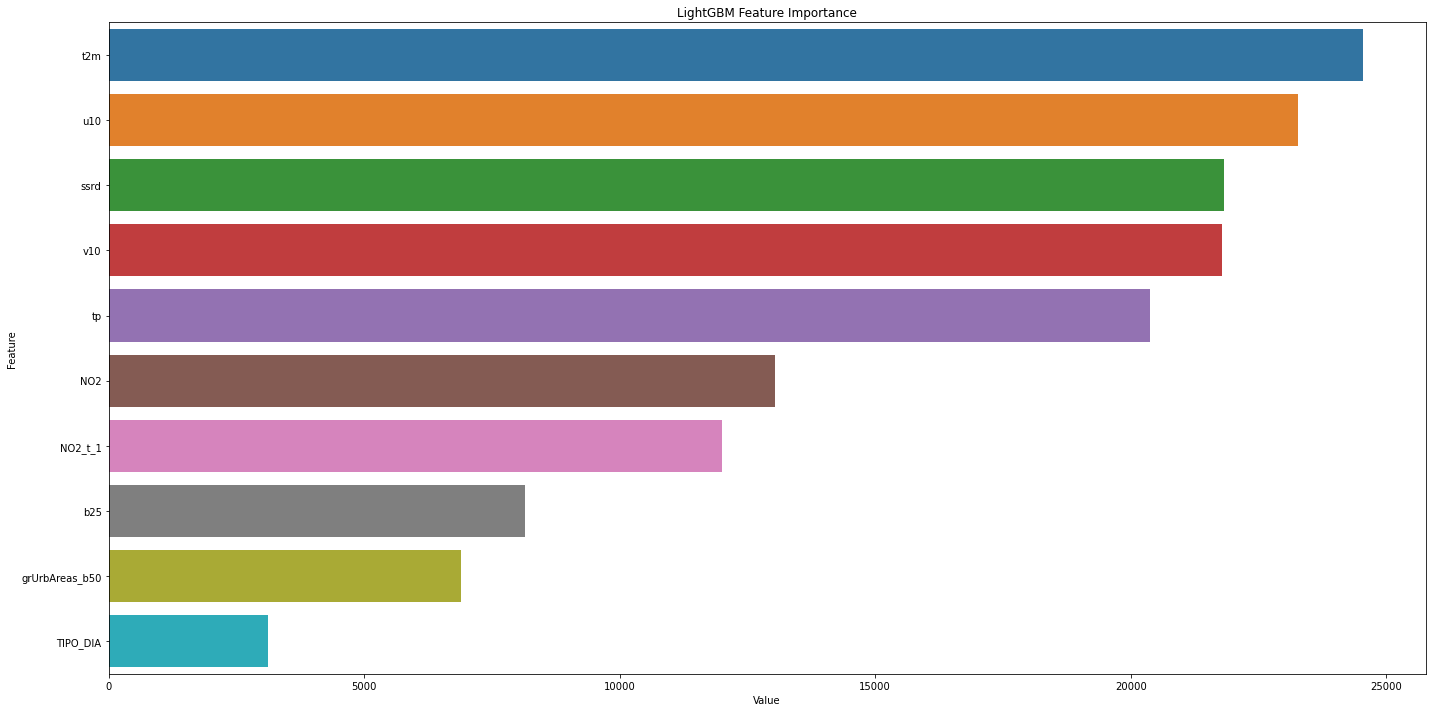

In [38]:
featImportancePlot(feature_imp_Memo3,'Memo3',25)

## MODELO 9: NO2 en t-1 + NO2 --> 15 mejores predictores

In [39]:
vars15 = list(feature_imp_memo1.iloc[0:15,:]['Feature'])
vars15.append('CODI EOI')
vars15.append('NO2_diff')
df9 = df[vars15]

In [40]:
train_data,val_data,X_test,y_test = conjuntoTrainValTest(df9,dfY)
model_Memo4,feature_imp_Memo4 = aplicacionModelo(params,'Memo4',False,train_data,val_data,X_test,y_test)

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### RESULTADOS MODELO ####

R2 : 0.8542 	 || 	 R2adj : 0.8542 	 || 	 Rpearson : 0.9244

Tiempo de ejecución: 0.41 minutos


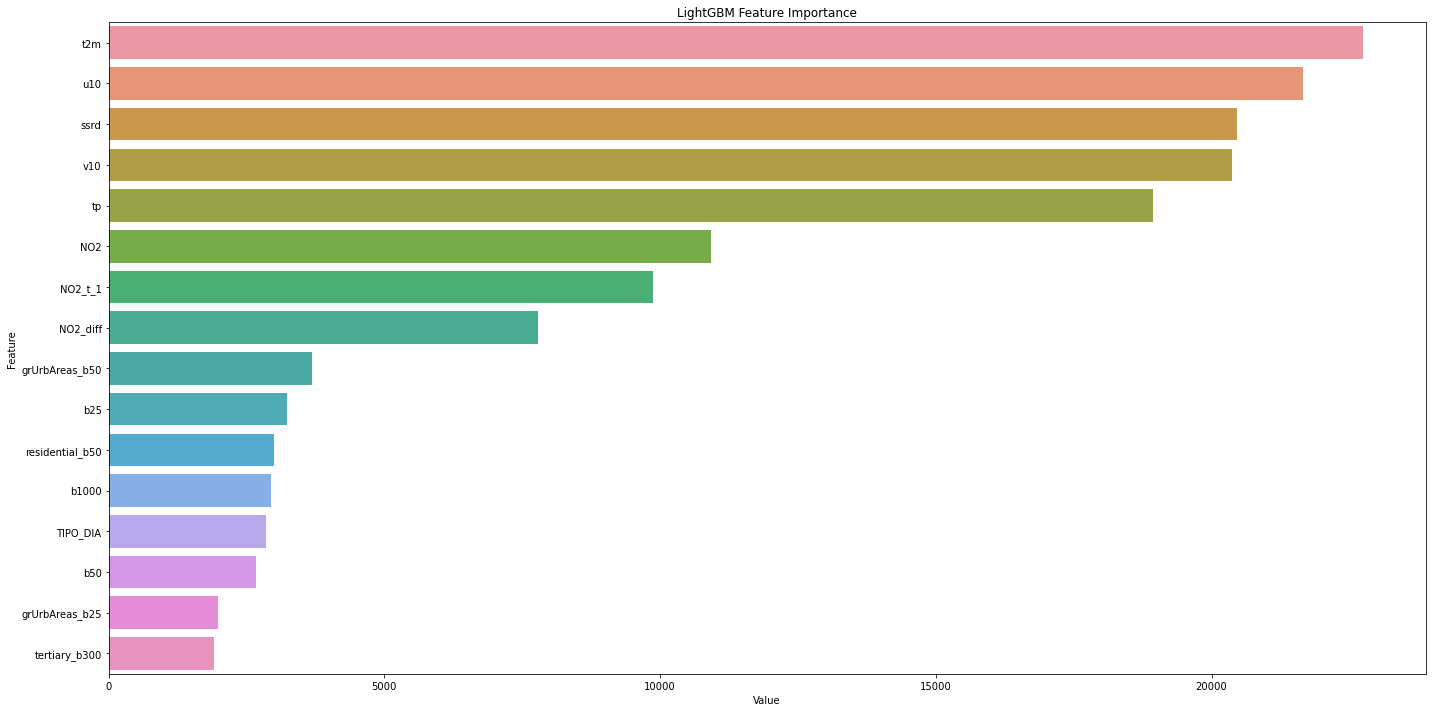

In [41]:
featImportancePlot(feature_imp_Memo4,'Memo4',25)

# MODELOS ESTACIONES

In [42]:
params = {'num_leaves': 32,
         'objective': 'regression',
         'boosting':'gbdt',
         'metric': 'rmse',
         'learning_rate': 0.1,         
         'verbose':-1}

1 - Procesando estación 8015021


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


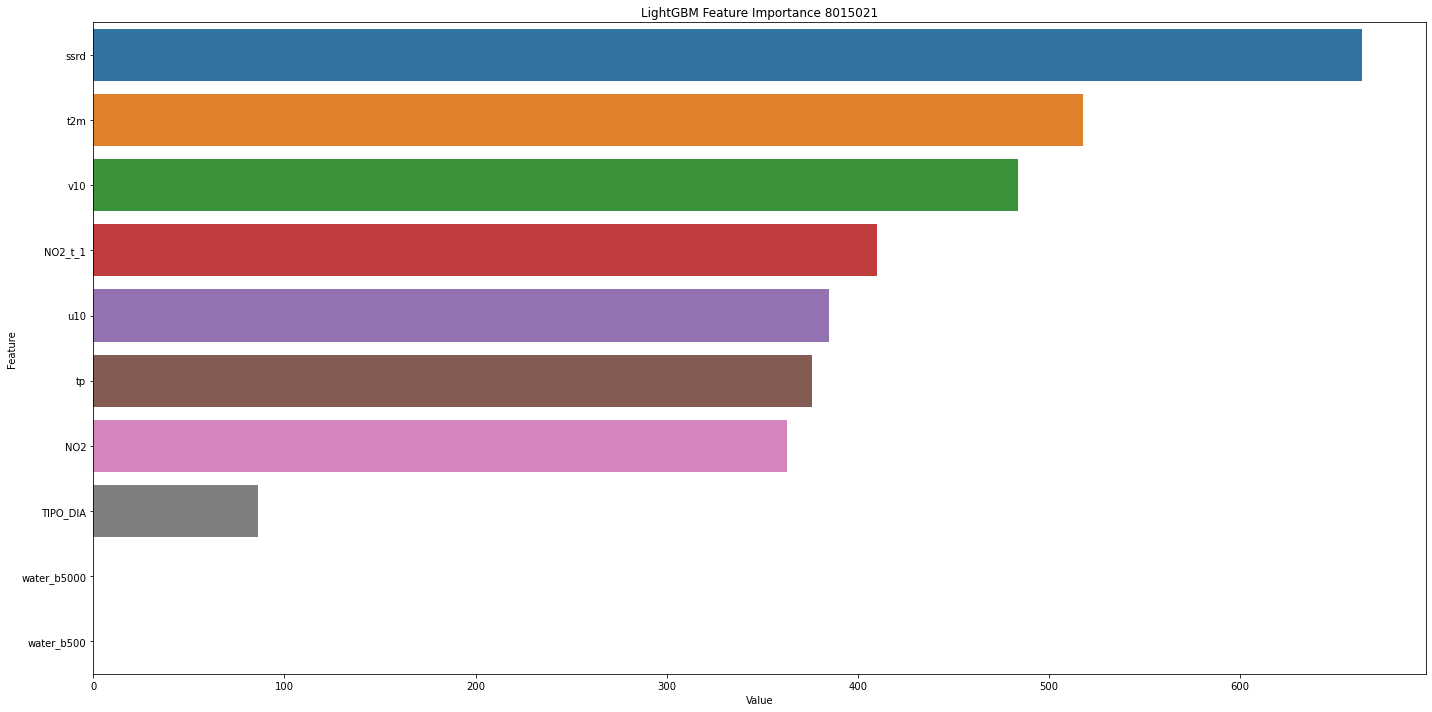

2 - Procesando estación 8019043


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


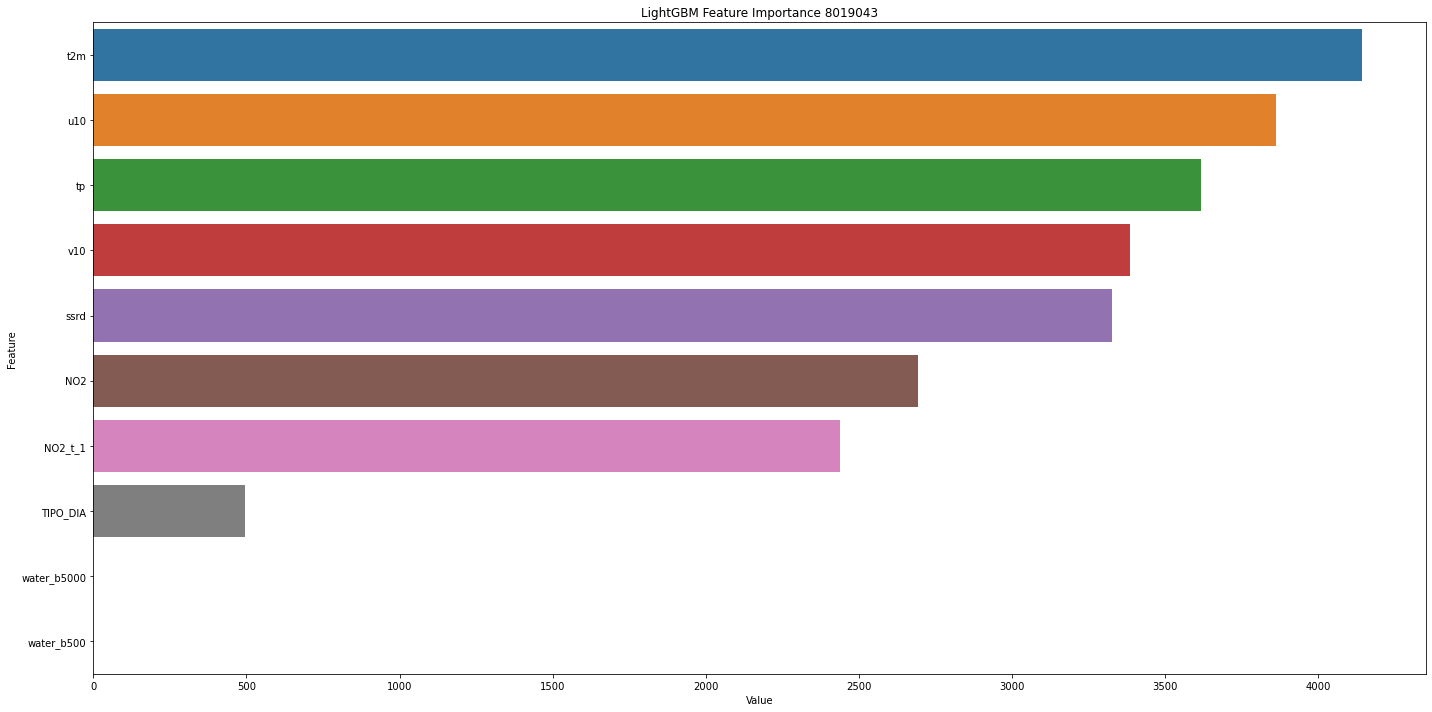

3 - Procesando estación 8019044


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


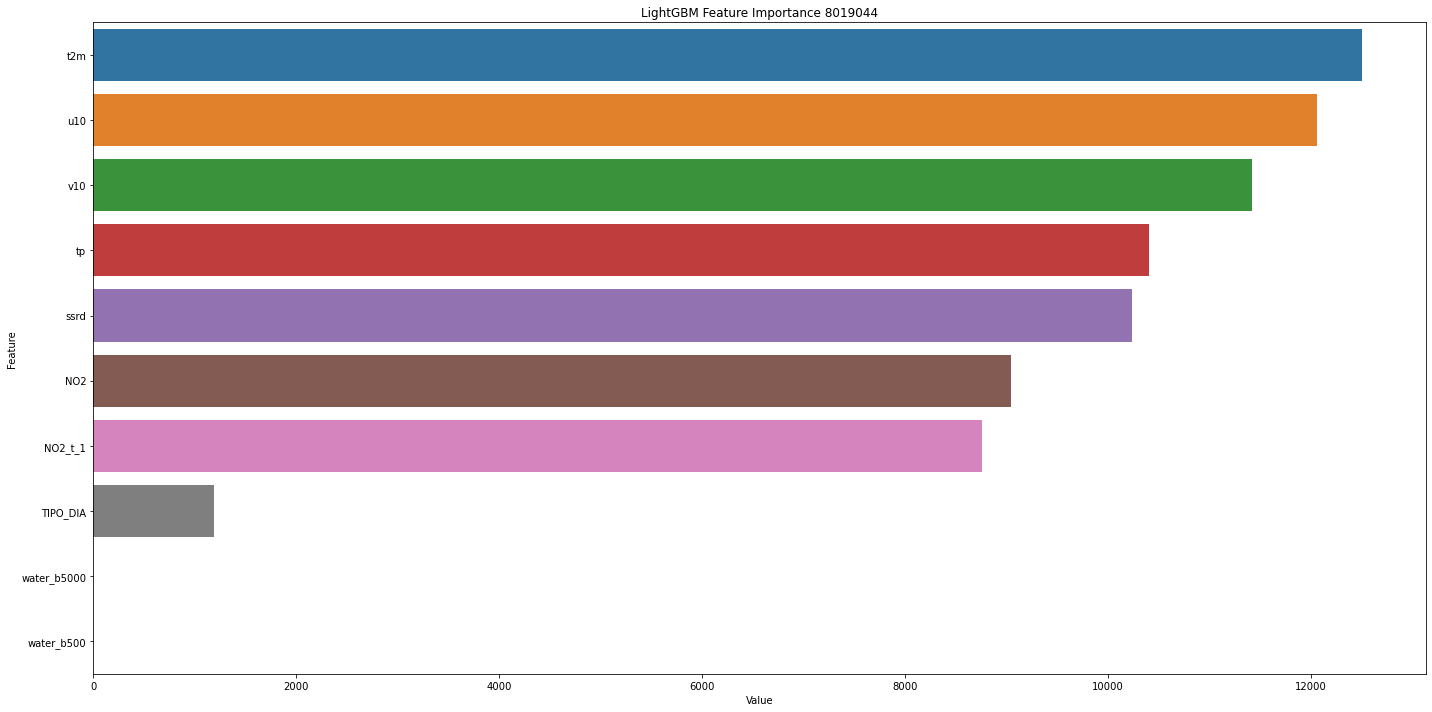

4 - Procesando estación 8019050


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


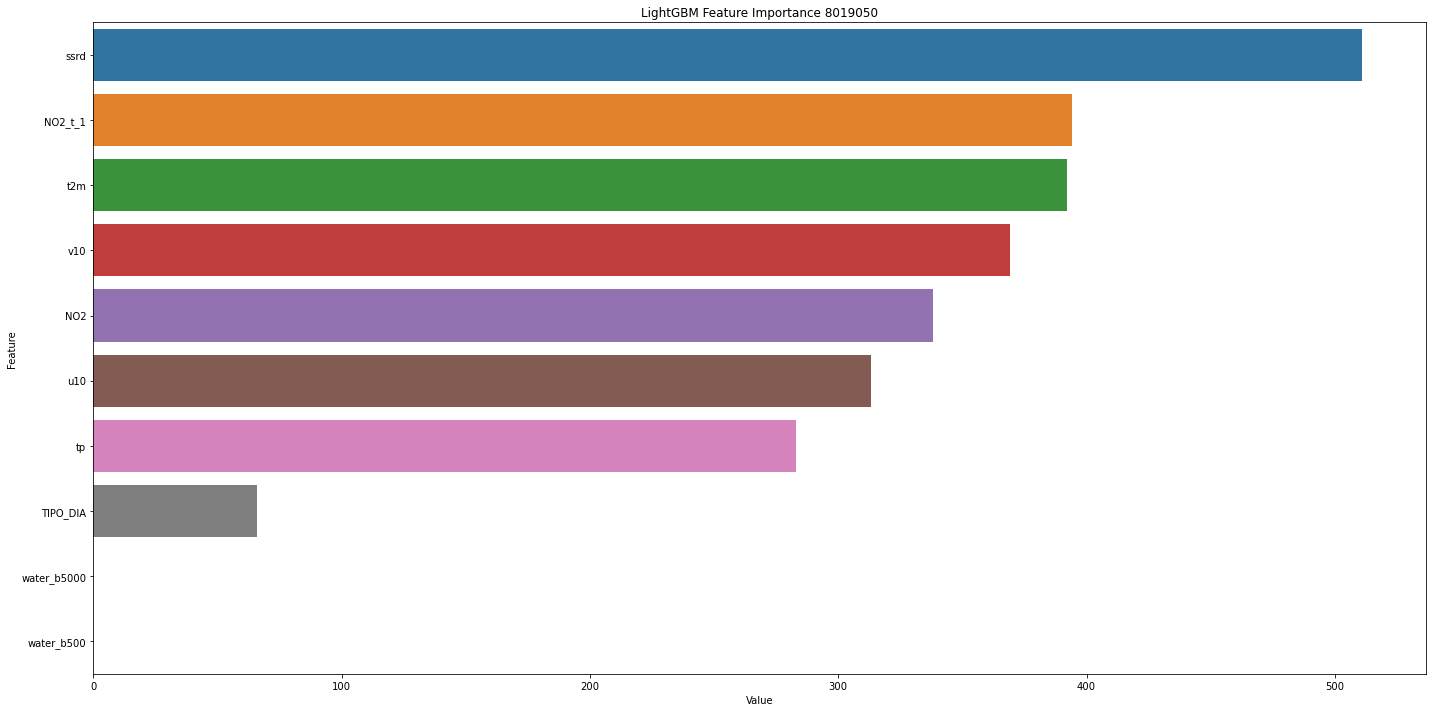

5 - Procesando estación 8019054


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


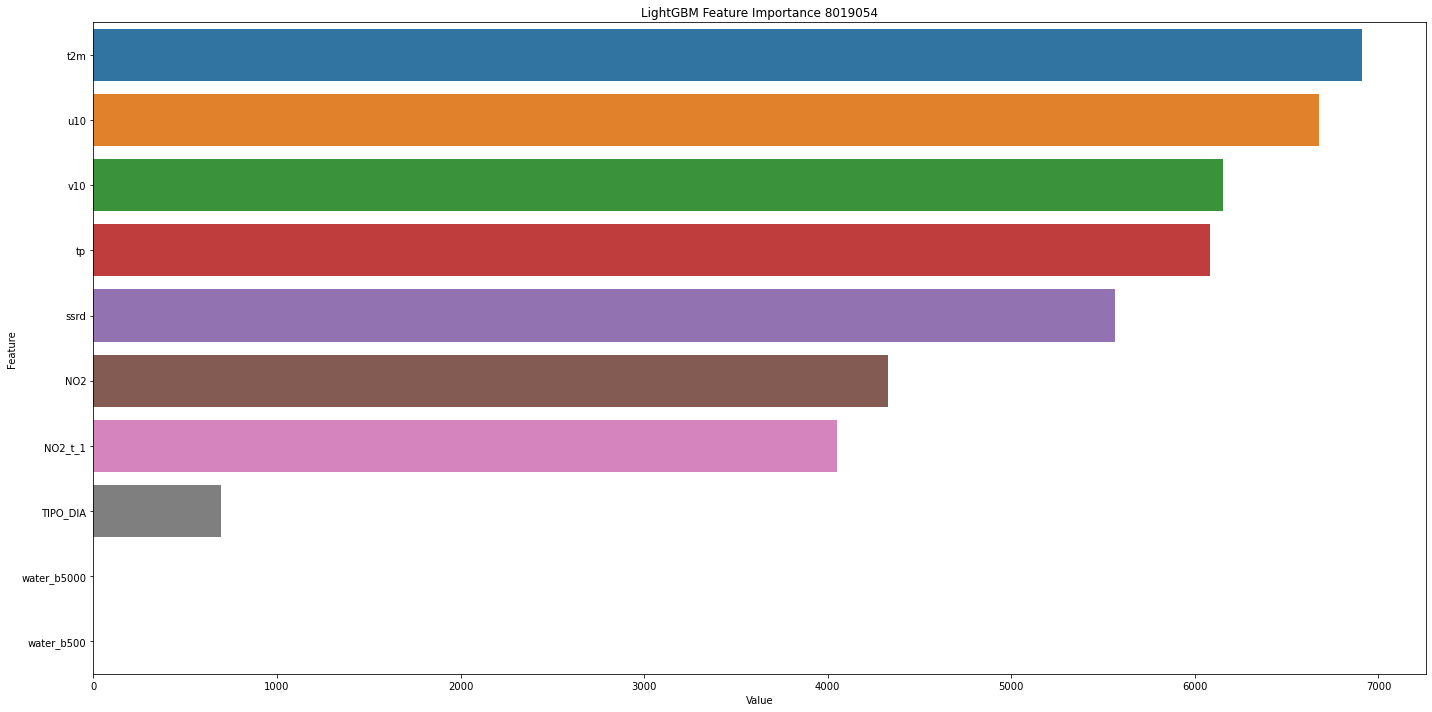

6 - Procesando estación 8019057


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


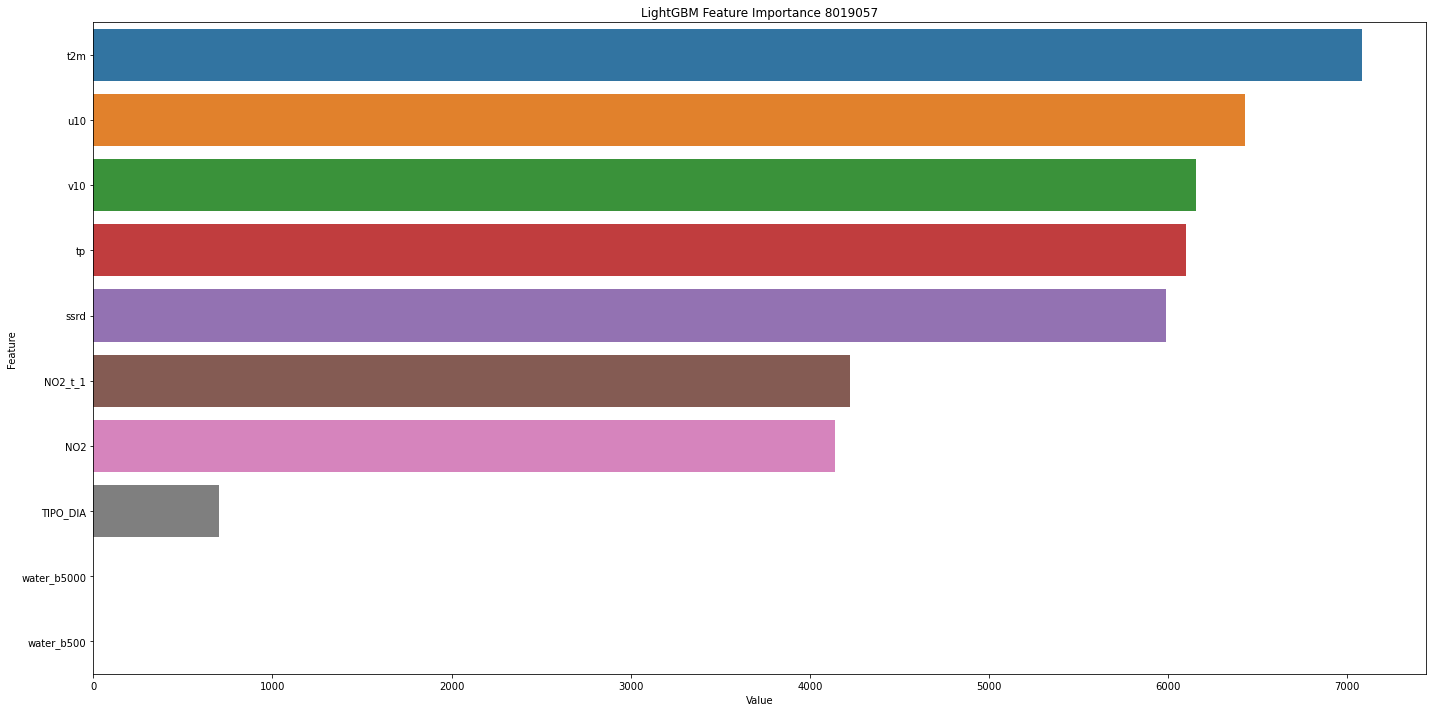

7 - Procesando estación 8019058


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


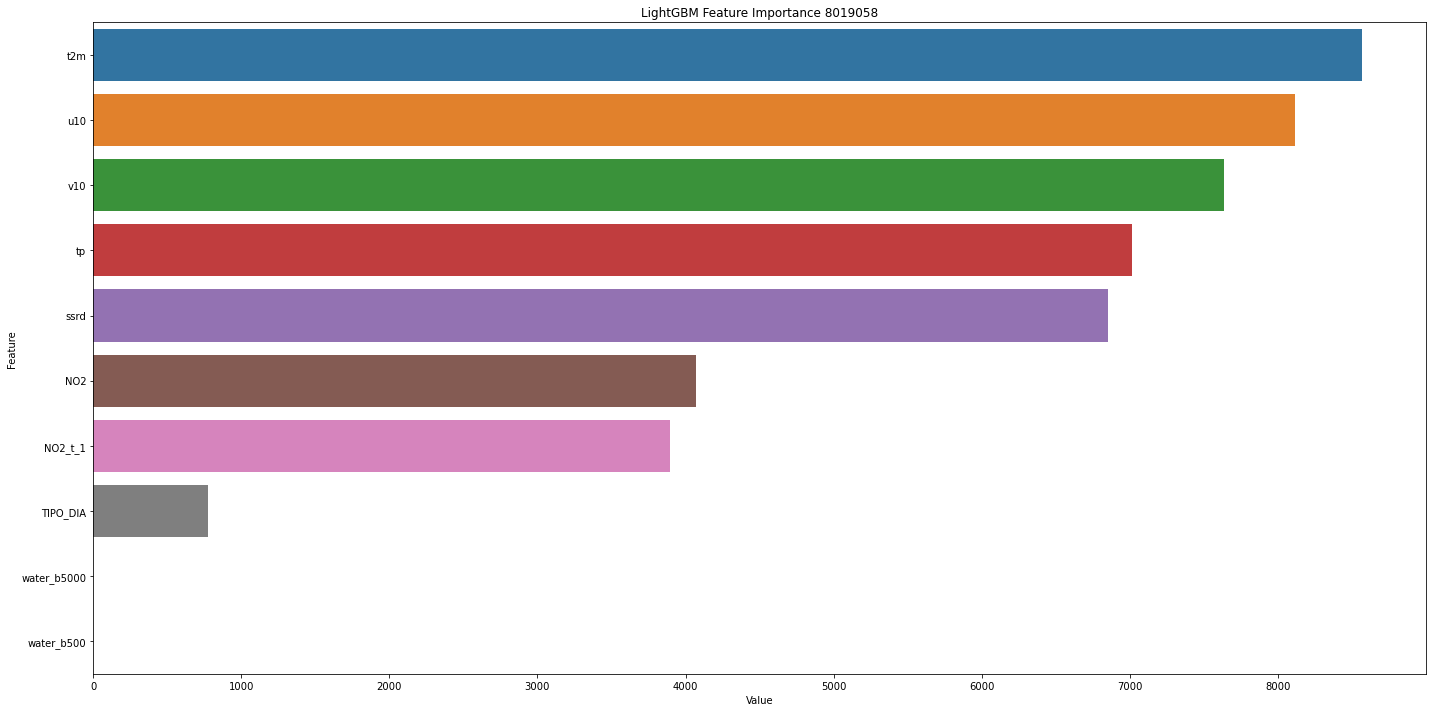

8 - Procesando estación 8089005


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


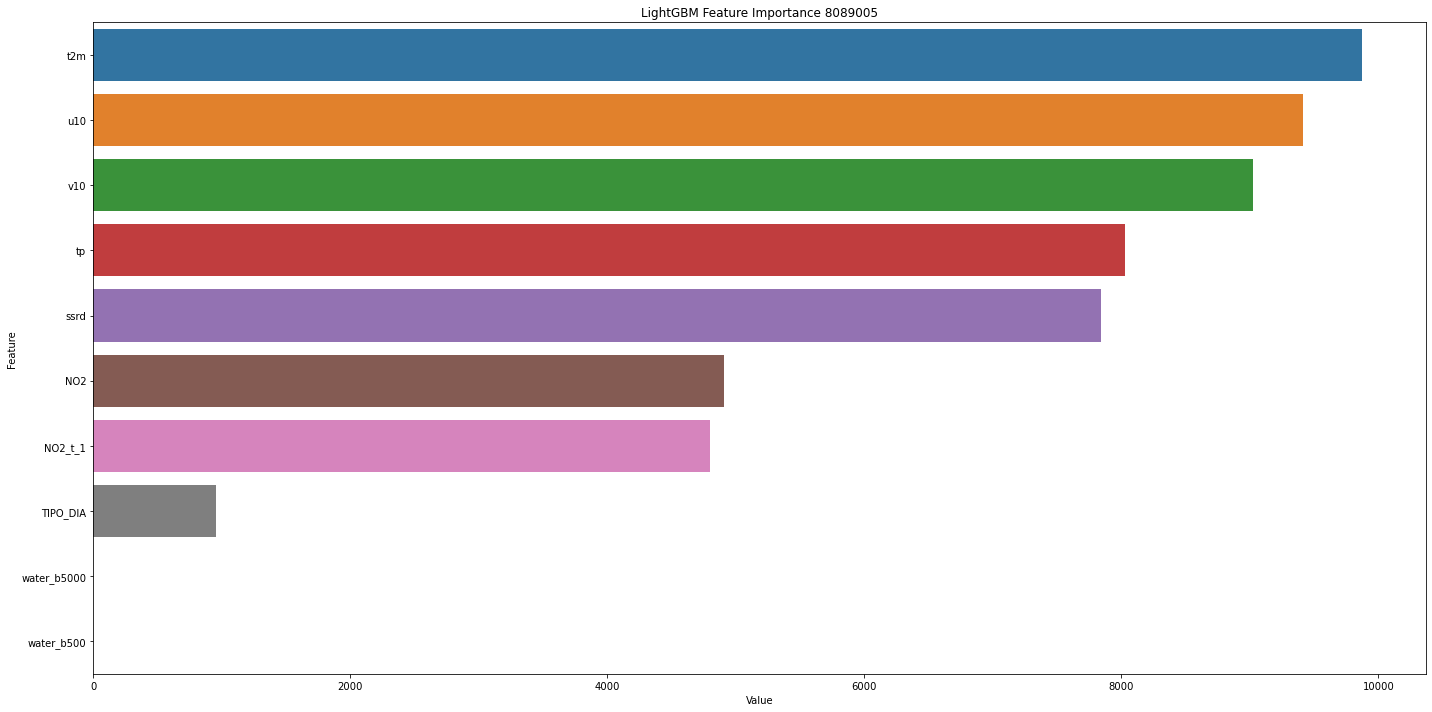

9 - Procesando estación 8125002


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


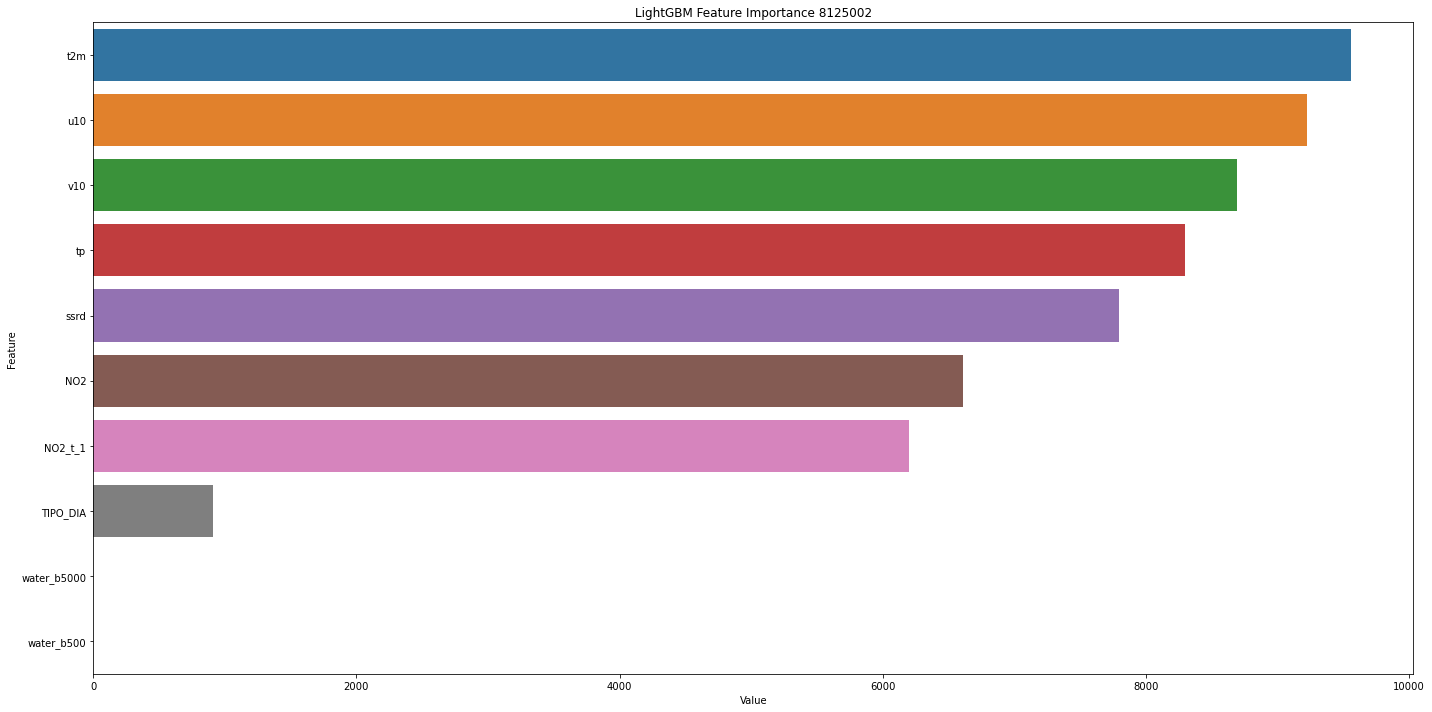

10 - Procesando estación 8169009


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


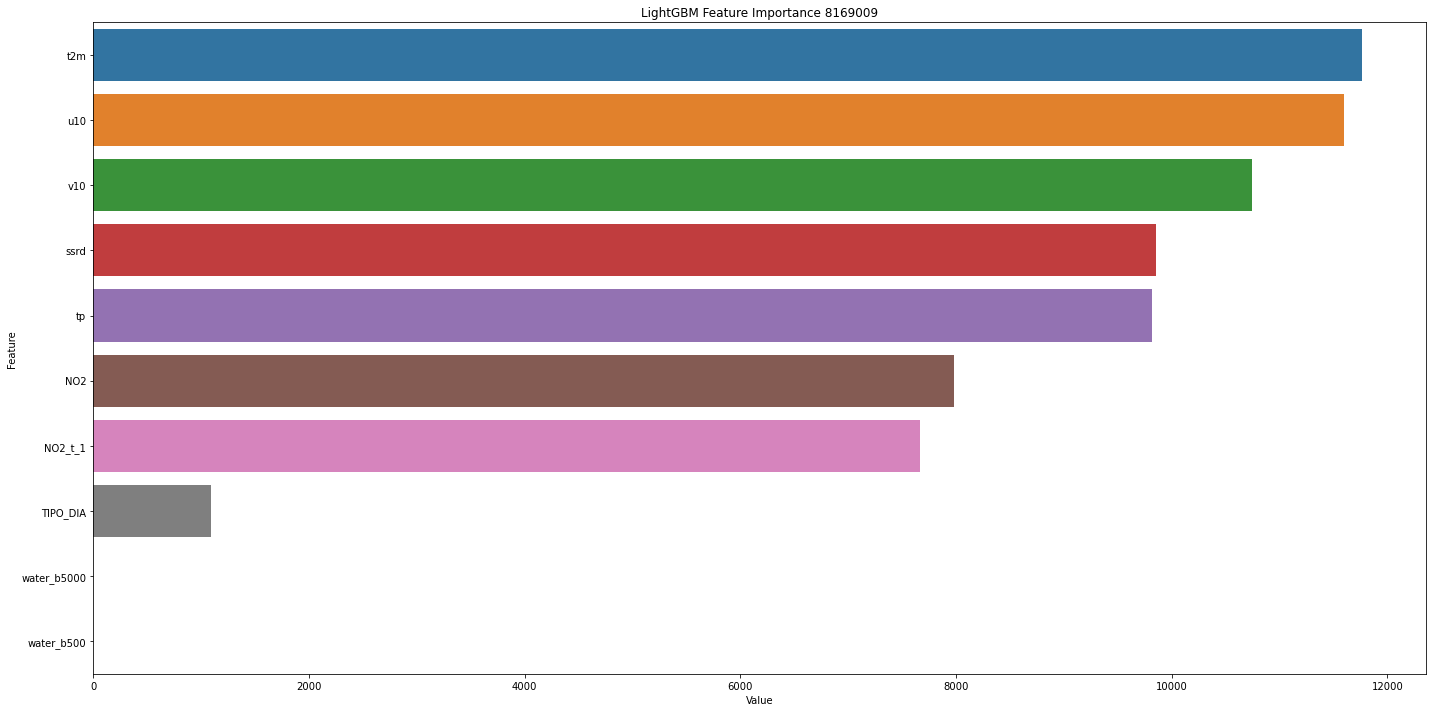

11 - Procesando estación 8194008


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


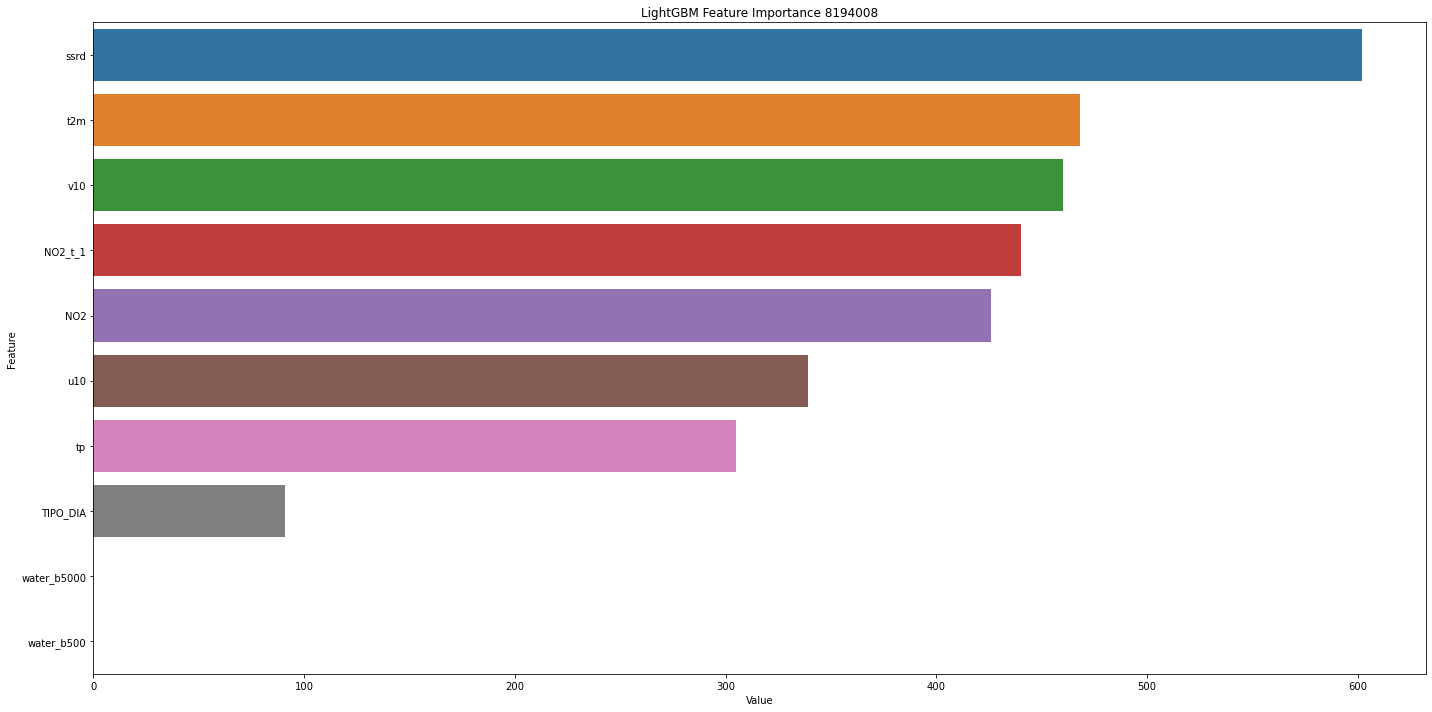

12 - Procesando estación 8205002


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


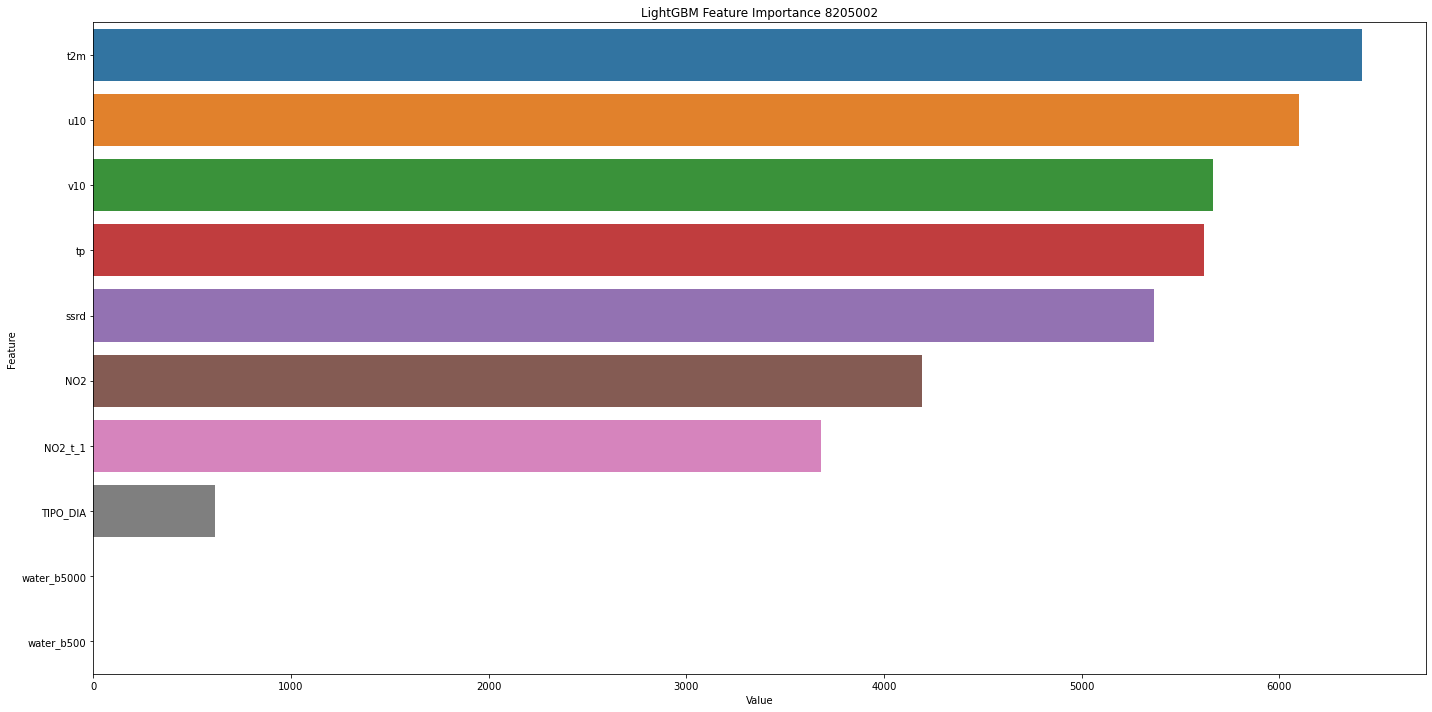

13 - Procesando estación 8263001


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


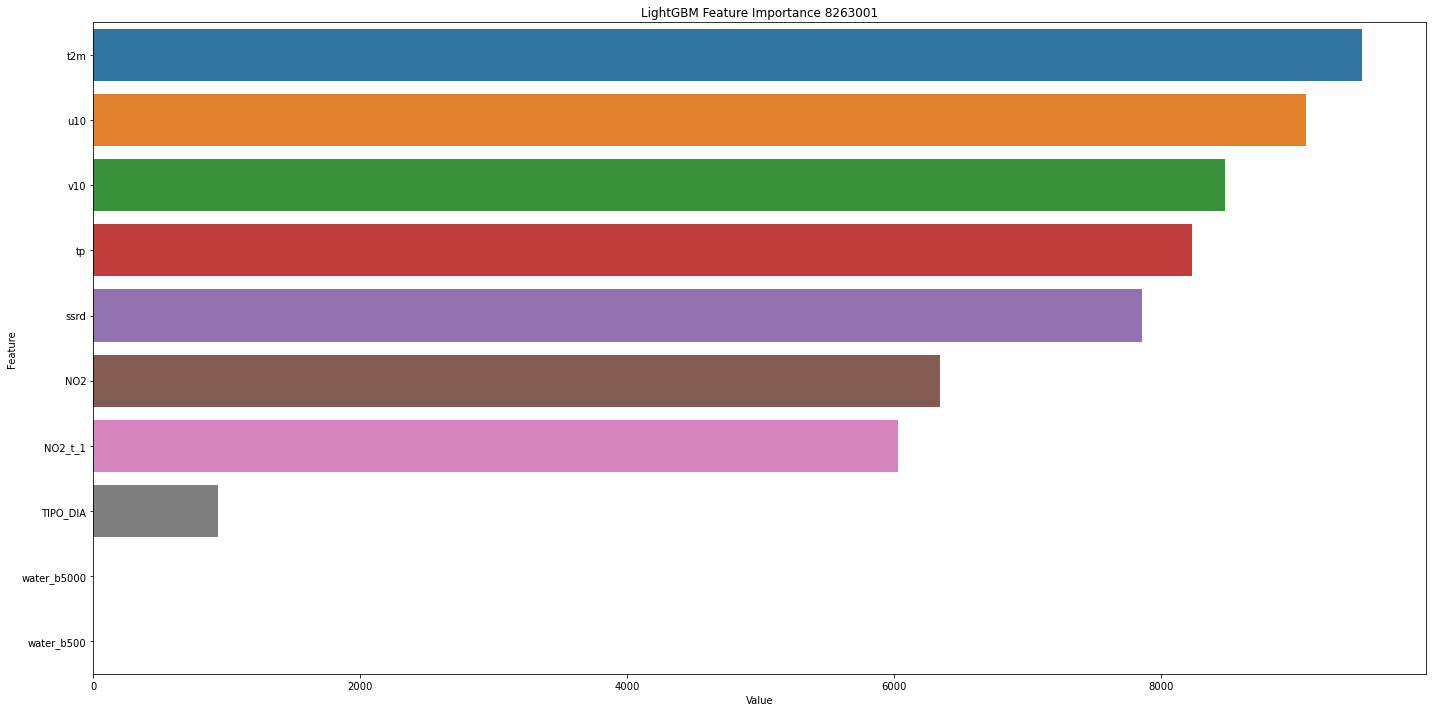

14 - Procesando estación 8301004


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


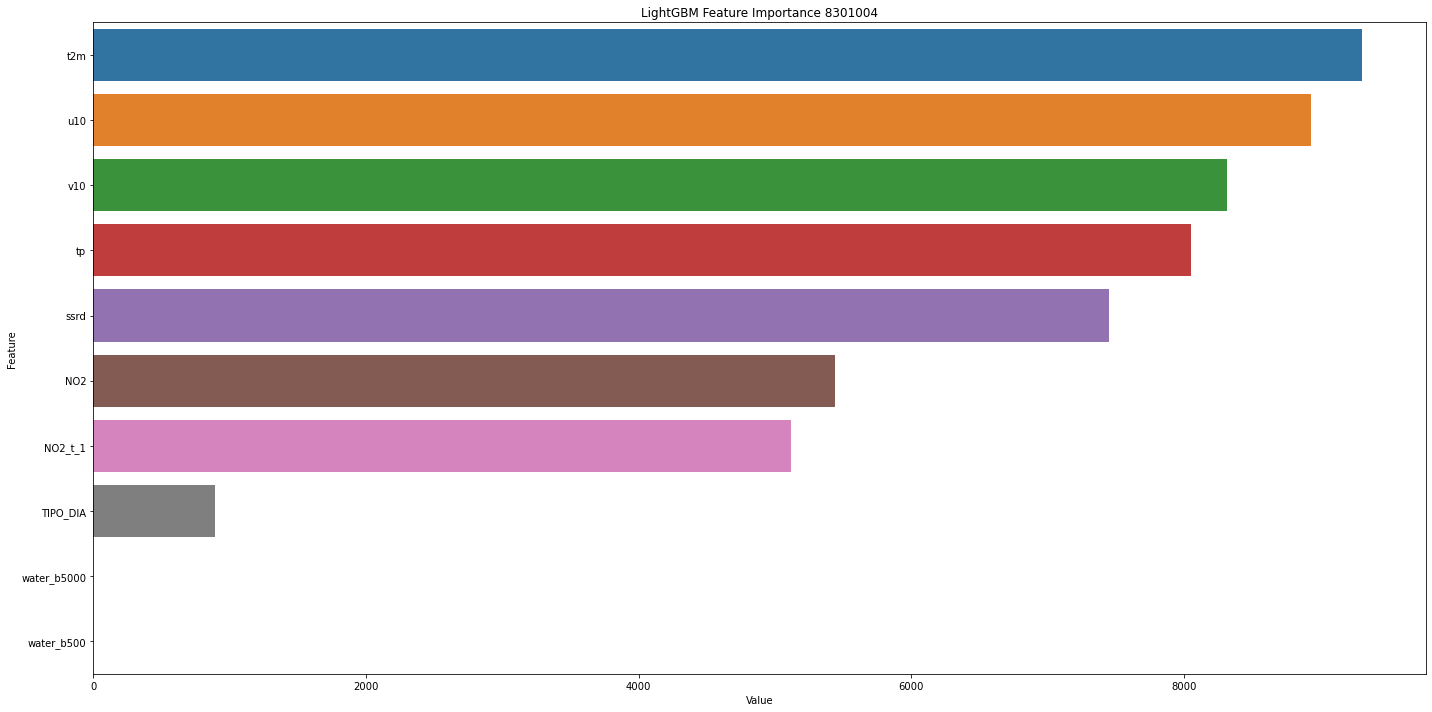

In [43]:
resultados,df_impacto, errorList_estaciones = modeloEstacionesInd(df,params)

Resultados de los modelos individuales de estación:

In [68]:
resultados.sort_values(by = ['Estacion'],inplace=True)
resultados

,Estacion,R2,R2adj,Pearson
0,8015021,0.640307,0.605948,0.800625
1,8019043,0.805692,0.786706,0.897627
2,8019044,0.837648,0.822119,0.915344
3,8019050,0.583645,0.543400,0.764022
4,8019054,0.847903,0.833085,0.920823
5,8019057,0.808799,0.787878,0.899401
6,8019058,0.694765,0.662072,0.833625
7,8089005,0.757708,0.734783,0.870767
8,8125002,0.881078,0.869407,0.938669
9,8169009,0.897369,0.887442,0.947310


Predictores por modelo:

In [44]:
df_impacto = df_impacto[df_impacto['Value']>0]

Numero de predictores por Estación:

In [45]:
df_impacto.groupby('Cod_Estacion').count()

,Feature,Value
Cod_Estacion,,
8015021,8,8
8019043,8,8
8019044,8,8
8019050,8,8
8019054,8,8
8019057,8,8
8019058,8,8
8089005,8,8
8125002,8,8


In [46]:
df_impacto.groupby('Feature').count()

,Cod_Estacion,Value
Feature,,
NO2,14,14
NO2_t_1,14,14
TIPO_DIA,14,14
ssrd,14,14
t2m,14,14
tp,14,14
u10,14,14
v10,14,14


# MODELO GENERAL 7 contra estaciones particulares

Carga modelos 6 y 7:

In [47]:
# memo1 = lgb.Booster(model_file='..\Datos\MODELOS\Generales\Modelo_Memo1.pkl')
memo2 = lgb.Booster(model_file='..\Datos\MODELOS\Generales\Modelo_Memo2.pkl')

Computar errores por estación del modelo memo1:

In [48]:
# estaciones = np.sort(df['CODI EOI'].unique())
# resultados_memo1 = pd.DataFrame()
# errorList_memo1 = []
# for i,v in enumerate(estaciones):
#     print(f'{i+1} - Procesando {v}')
#     # Filtrar estación
#     dfX = df[df['CODI EOI'] == v]
#     dfX_aux = dfX.iloc[:,np.r_[2,3,5:434]]
#     dfY = dfX[['O3']]
#     # Predicción y R2
#     y_pred = memo1.predict(dfX_aux)
#     # Error
#     e = np.hstack(np.array(dfY)) - y_pred
#     errorList_memo1.append(e)
#     # R2
#     r2 = r2_score(dfY, y_pred)
#     # R2 adjusted
#     n = X_test.shape[0]
#     p = X_test.shape[1]
#     r2_adj = (1-(1-r2)*(n-1)/(n-p-1))
#     # Pearson Corr
#     pearson = np.corrcoef(np.hstack(np.array(dfY)), y_pred)[0][1]
#     # DF resultados
#     auxList = [str(v),r2,r2_adj,pearson]
#     resultados_memo1 = resultados_memo1.append([auxList])
# resultados_memo1.columns = ['Estacion','R2','R2adj','Pearson']

1 - Procesando 8015021
2 - Procesando 8019043
3 - Procesando 8019044
4 - Procesando 8019050
5 - Procesando 8019054
6 - Procesando 8019057
7 - Procesando 8019058
8 - Procesando 8089005
9 - Procesando 8125002
10 - Procesando 8169009
11 - Procesando 8194008
12 - Procesando 8205002
13 - Procesando 8263001
14 - Procesando 8301004


Computar errores por estación del modelo memo2:

In [94]:
dfX = df_15[df_15['CODI EOI'] == v]
dfY = dfX[['O3']]
dfX.drop(columns=['O3'],axis=1,inplace=True)
# Replicación conjunto de entrenamiento
X_train, X_test, y_train, y_test = train_test_split(dfX, 
                                                    dfY, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=dfX['CODI EOI'])

C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [99]:
resultados_memo2 = pd.DataFrame()
df_15 = df[['t2m','u10','v10','ssrd','tp','NO2','NO2_t_1','TIPO_DIA','b25','grUrbAreas_b50','grUrbAreas_b25',
            'b50','b1000','tertiary_b300','residential_b50','CODI EOI','O3']]
errorList_memo2 = []
for i,v in enumerate(estaciones):
    print(f'{i+1} - Procesando {v}')
    # Filtrar estación
    dfX = df_15[df_15['CODI EOI'] == v]
    dfY = dfX[['O3']]
    dfX.drop(columns=['O3'],axis=1,inplace=True)
    # Replicación conjunto de entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(dfX, 
                                                        dfY, 
                                                        test_size=0.2, 
                                                        random_state=42,
                                                        stratify=dfX['CODI EOI'])
    # Eliminación columnas CODI EOI y O3
    X_test.drop(columns=['CODI EOI'],axis=1,inplace=True)
    # Predicción y R2
    y_pred = memo2.predict(X_test)
    # Error
    e = np.hstack(np.array(y_test)) - y_pred
    errorList_memo2.append(e)
    # R2
    r2 = r2_score(y_test, y_pred)
    # R2 adjusted
    n = X_test.shape[0]
    p = X_test.shape[1]
    r2_adj = (1-(1-r2)*(n-1)/(n-p-1))
    # Pearson Corr
    pearson = np.corrcoef(np.hstack(np.array(y_test)), y_pred)[0][1]
    # DF resultados
    auxList = [str(v),r2,r2_adj,pearson]
    resultados_memo2 = resultados_memo2.append([auxList])
resultados_memo2.columns = ['Estacion','R2','R2adj','Pearson']

1 - Procesando 8015021


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


2 - Procesando 8019043


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


3 - Procesando 8019044


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


4 - Procesando 8019050


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


5 - Procesando 8019054


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


6 - Procesando 8019057


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


7 - Procesando 8019058


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


8 - Procesando 8089005


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


9 - Procesando 8125002


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


10 - Procesando 8169009


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


11 - Procesando 8194008


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


12 - Procesando 8205002


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


13 - Procesando 8263001


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


14 - Procesando 8301004


C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\iarregui\anaconda3\envs\geo_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [103]:
resultados_memo2.sort_values(by = ['Estacion'],inplace = True)
resultados_memo2

,Estacion,R2,R2adj,Pearson
0,8015021,0.730640,0.729820,0.856129
0,8019043,0.904872,0.904576,0.952264
0,8019044,0.922647,0.922411,0.960726
0,8019050,0.789322,0.788673,0.890570
0,8019054,0.925363,0.925132,0.962389
0,8019057,0.898567,0.898217,0.948612
0,8019058,0.833104,0.832540,0.913892
0,8089005,0.858829,0.858403,0.927564
0,8125002,0.923468,0.923230,0.961102
0,8169009,0.930665,0.930451,0.964874


In [50]:
# resultados_memo1.to_csv('..\Datos\MODELOS\Resultados_Modelo_Memo1_Estaciones.csv')
resultados_memo2.to_csv('..\Datos\MODELOS\Resultados_Modelo_Memo2_Estaciones.csv')

# ANALISIS DE ERRORES

In [51]:
estaciones = np.sort(df['CODI EOI'].unique())

## Modelo Memo1

In [52]:
# errorList_memo1
# np.save('..\Datos\MODELOS\Errores\errorList_memo1.npy', errorList_memo1)

In [53]:
#errorList_memo1 = list(np.load('..\Datos\MODELOS\Errores\errorList_memo1.npy', allow_pickle = True))

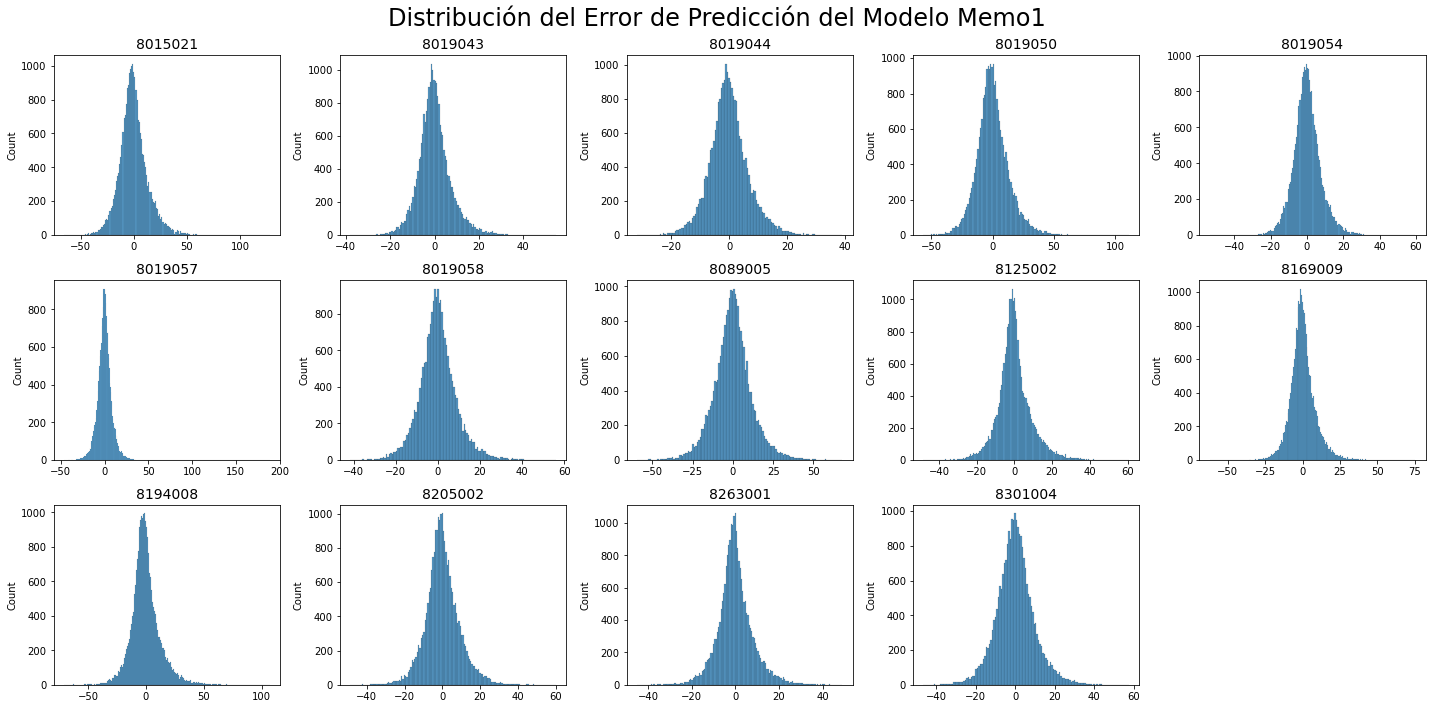

In [54]:
# fig = plt.figure(figsize=(20,10))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)
# for i,est in enumerate(estaciones):
#     j = i + 1
#     ax = fig.add_subplot(3, 5, j)
#     data = errorList_memo1[i]
#     sns.histplot(data,ax = ax)
#     ax.set_title(f'{est}', size=14)
# plt.suptitle("Distribución del Error de Predicción del Modelo Memo1", size=24)
# plt.tight_layout()

## Modelo Memo2

In [55]:
# np.save('..\Datos\MODELOS\Errores\errorList_memo2.npy', errorList_memo2)
# errorList_memo2 = list(np.load('..\Datos\MODELOS\Errores\errorList_memo2.npy', allow_pickle = True))

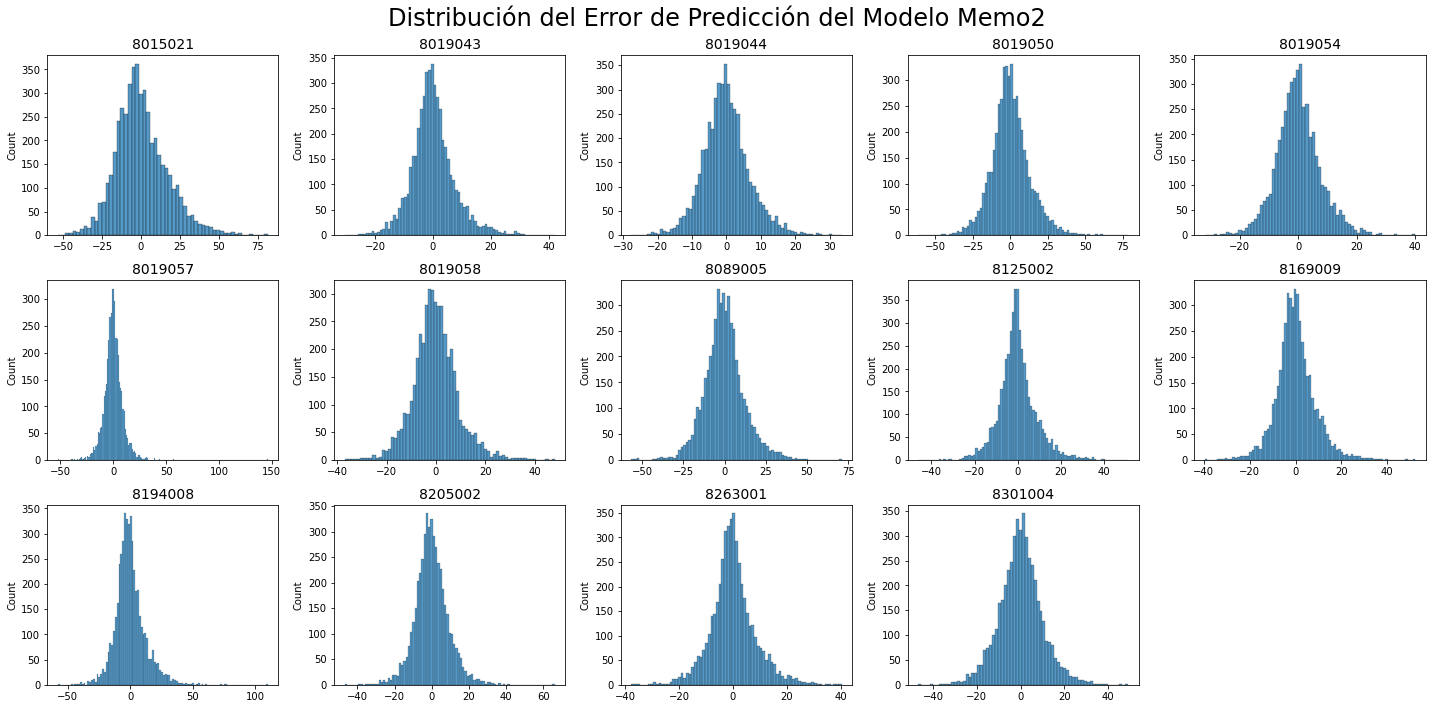

In [102]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,est in enumerate(estaciones):
    j = i + 1
    ax = fig.add_subplot(3, 5, j)
    data = errorList_memo2[i]
    sns.histplot(data,ax = ax)
    ax.set_title(f'{est}', size=14)
plt.suptitle("Distribución del Error de Predicción del Modelo Memo2", size=24)
plt.tight_layout()

## Modelos Particulares

In [57]:
# np.save('..\Datos\MODELOS\Errores\errorList_estaciones.npy', errorList_estaciones)
# errorList_estaciones = list(np.load('..\Datos\MODELOS\Errores\errorList_estaciones.npy', allow_pickle = True))

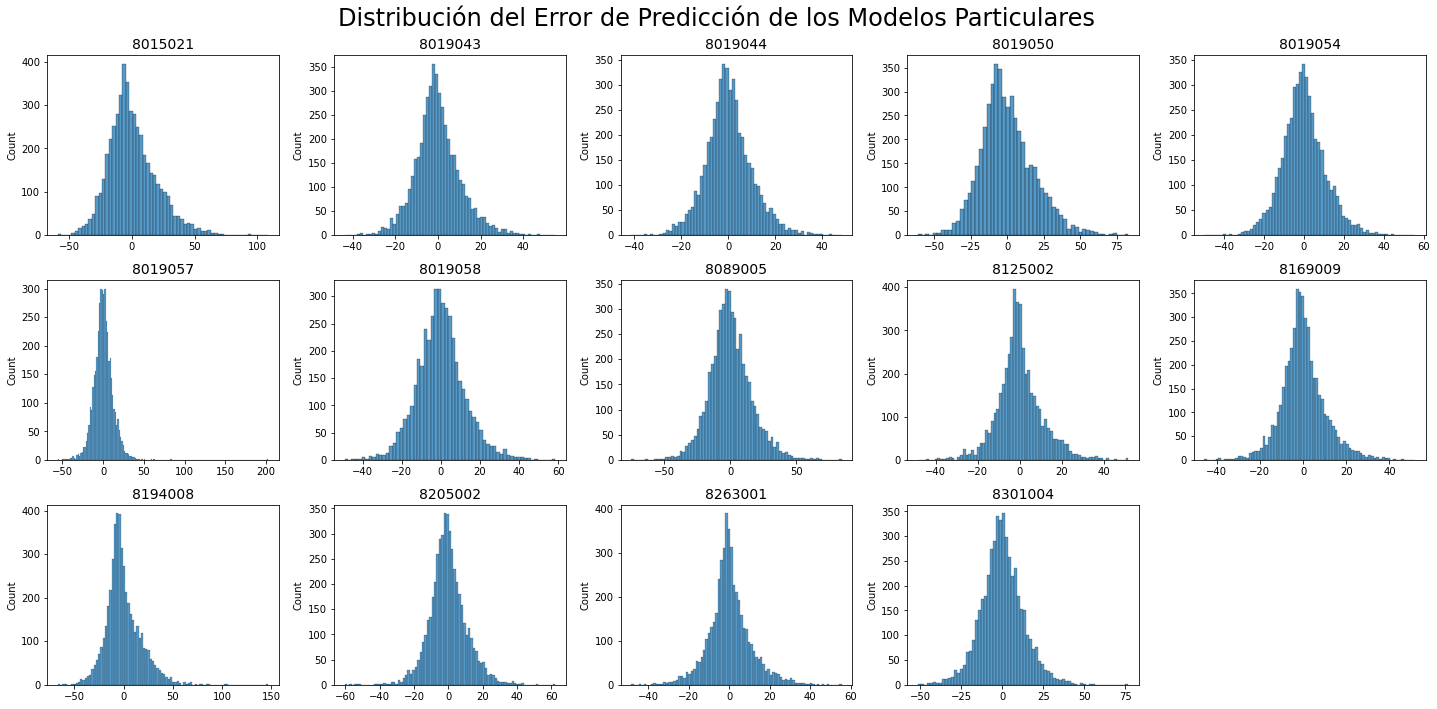

In [58]:
fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i,est in enumerate(estaciones):
    j = i + 1
    ax = fig.add_subplot(3, 5, j)
    data = errorList_estaciones[i]
    sns.histplot(data,ax = ax)
    ax.set_title(f'{est}', size=14)
plt.suptitle("Distribución del Error de Predicción de los Modelos Particulares", size=24)
plt.tight_layout()